# `make_circles` dataset with gaussian noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logitboost_j_implementation as logitboost
import calibration_functions as calibration
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import lmt_final_implementation as lmt
from sklearn import tree

**noise : float, default = *None***  
Standard deviation of Gaussian noise added to the data.

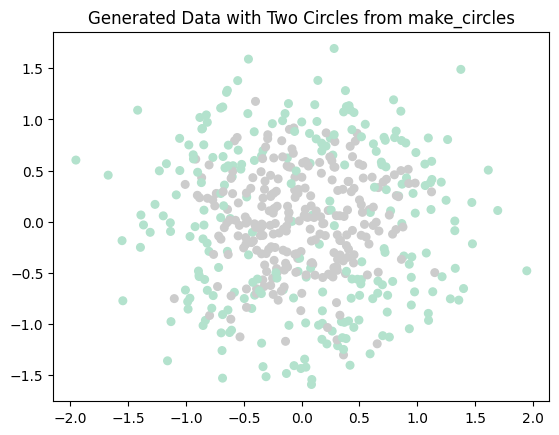

Shape of X2: (500, 2)
Shape of y2: (500,)


In [2]:
X, y = make_circles(n_samples=500, noise=0.35, factor=0.4, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Pastel2)    
plt.title("Generated Data with Two Circles from make_circles")
plt.show()

print("Shape of X2:", X.shape)
print("Shape of y2:", y.shape)

In [9]:
y.sum()

250

In [3]:
# Adding the third term to the dataset
# X1^2 + X2^2
X_ext = np.hstack((X, (np.sum(X**2, axis=1).reshape(-1, 1))))
X_ext

array([[-0.8461339 ,  0.75211469,  1.28161909],
       [-0.27971753,  0.10621719,  0.08952399],
       [ 0.45349498,  0.32595298,  0.31190304],
       ...,
       [-1.95193075,  0.60281687,  4.17342185],
       [ 0.17354895,  0.76811445,  0.62011905],
       [-0.33372821, -1.41702322,  2.11932933]])

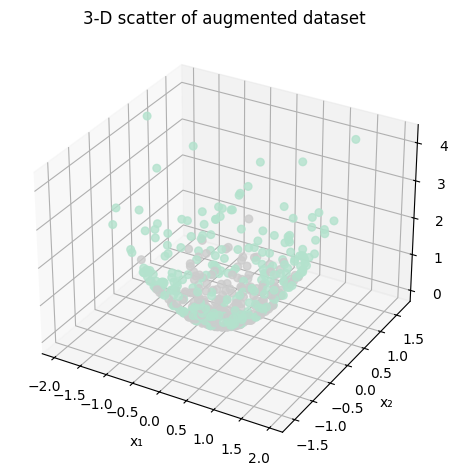

In [4]:
from mpl_toolkits.mplot3d import Axes3D          # registers the 3-D projection

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# X_ext  → shape (n_samples, 3)
# y      → 1-D array of class labels you got from make_blobs
ax.scatter(X_ext[:, 0], X_ext[:, 1], X_ext[:, 2], c=y, alpha=0.8, cmap=plt.cm.Pastel2, s=30)

ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.set_zlabel("x₁² + x₂²")
plt.title("3-D scatter of augmented dataset")
plt.tight_layout()
plt.show()


In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ext, y, test_size=0.3, random_state=42)

## LogitBoost *J* classes

In [6]:
# Fit the LogitBoost model
learners1, J1 = logitboost.logitboost_fit(X_train[:,:2], y_train, n_estimators=500)

# Predict using the fitted model on test set
y_pred1 = logitboost.logitboost_predict(X_test[:,:2], learners1, J1)
y_proba1 = logitboost.logitboost_predict_proba(X_test[:,:2], learners1, J1)

# Evaluate the model
acc1 = accuracy_score(y_test, y_pred1)
roc1 = roc_auc_score(y_test, y_proba1[:, 1])
log_loss1 = log_loss(y_test, y_proba1)

# Print results for original make_circles
print(f"Log-loss on original make_circles: {log_loss1:.4f}")
print(f"Accuracy on original make_circles: {acc1:.4f}")
print(f"ROC AUC on original make_circles: {roc1:.4f}")

Log-loss on original make_circles: 0.6949
Accuracy on original make_circles: 0.5400
ROC AUC on original make_circles: 0.5257


In [11]:
# Visualize the class predictions
def plot_decision_boundary(
        X, y, learners, J,
        title="Decision boundary",
        fill_value="mean",       # cómo rellenar las dimensiones extra: "mean" | "median" | float
        h=0.01                   # paso de la rejilla
    ):
    """
    X : array (n_samples, D)         Datos completos.
    y : array (n_samples,)           Etiquetas de 0 … J-1.
    J : int                          Número de clases.
    learners : objeto(s) del modelo  Pasan a logitboost_predict.
    title : str                      Título de la figura.
    fill_value : str | float         Cómo rellenar dims 3…D para la rejilla.
    h : float                        Resolución de la rejilla.
    """

    # --- 1. Preparar rejilla en las primeras dos dimensiones -----------------
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # --- 2. Construir matriz completa para el predictor -----------------------
    n_grid = xx.size
    X_grid = np.zeros((n_grid, 2))
    X_grid[:, 0] = xx.ravel()
    X_grid[:, 1] = yy.ravel()

    if X.shape[1] > 2:
        X_grid = np.hstack((X_grid, (np.sum(X_grid**2, axis=1).reshape(-1, 1))))

    # --- 3. Predicción --------------------------------------------------------
    Z = logitboost.logitboost_predict(X_grid, learners, J=J)   # (n_grid,) con etiquetas 0…J-1
    Z = Z.reshape(xx.shape)

    # --- 4. Dibujar -----------------------------------------------------------
    # 4.1 Puntos de entrenamiento
    plt.figure(figsize=(8, 6))
    J = len(np.unique(y))

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set2,
                s=30, edgecolors='k')

    # 4.2 Frontera de decisión
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set2)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()

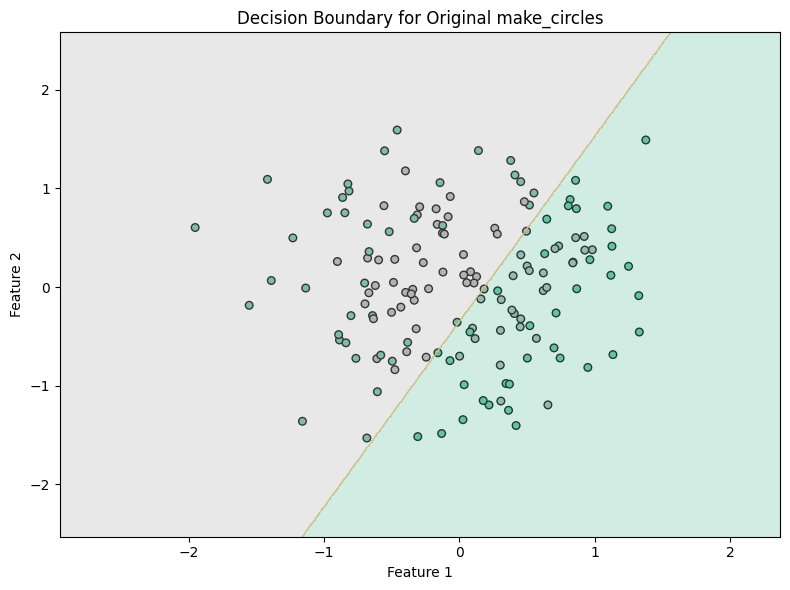

In [12]:
plot_decision_boundary(X_test[:,:2], y_test, learners1, J1,
                       title="Decision Boundary for Original make_circles",)

In [13]:
# Fit the LogitBoost model
learners2, J2 = logitboost.logitboost_fit(X_train, y_train, n_estimators=500)

# Predict using the fitted model on test set
y_pred2 = logitboost.logitboost_predict(X_test, learners2, J2)
y_proba2 = logitboost.logitboost_predict_proba(X_test, learners2, J2)

# Evaluate the model
acc2 = accuracy_score(y_test, y_pred2)
log_loss2 = log_loss(y_test, y_proba2)
roc2 = roc_auc_score(y_test, y_proba2[:, 1])

# Print results for extended make_circles
print(f"Log-loss on extended make_circles: {log_loss2:.4f}")
print(f"Accuracy on extended make_circles: {acc2:.4f}")
print(f"ROC AUC on extended make_circles: {roc2:.4f}")

Log-loss on extended make_circles: 0.4704
Accuracy on extended make_circles: 0.7667
ROC AUC on extended make_circles: 0.8600


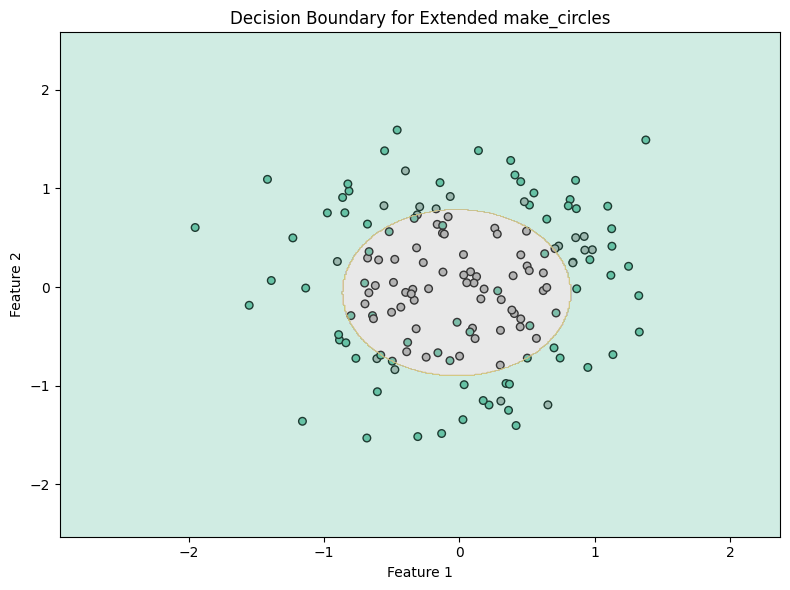

In [14]:
plot_decision_boundary(X_test, y_test, learners2, J2, title="Decision Boundary for Extended make_circles")

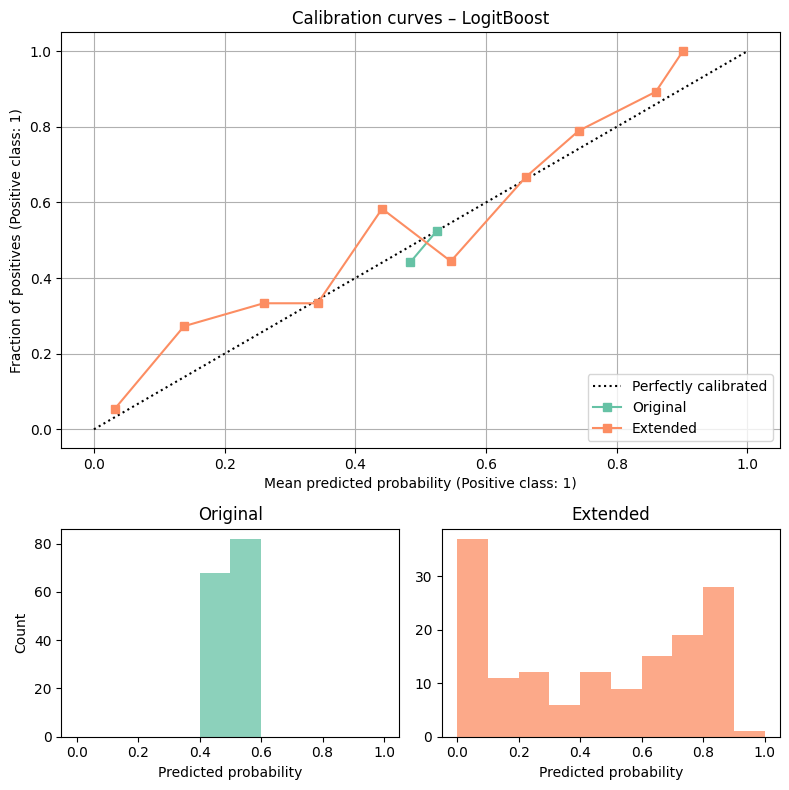

In [15]:
# ------------------------------------------------------------
# 1.  Get class-probability estimates for each model
# ------------------------------------------------------------
#  -> keep only the probability of the positive class (column 1)
proba_orig = logitboost.logitboost_predict_proba(X_test[:,:2], learners1, J1)[:, 1]
proba_ext  = logitboost.logitboost_predict_proba(X_test, learners2, J2)[:, 1]

# ------------------------------------------------------------
# 2.  Draw calibration plots
# ------------------------------------------------------------
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs  = GridSpec(nrows=2, ncols=2, height_ratios=[2, 1])

ax_curve = fig.add_subplot(gs[0, :])                 # big panel for the curves
ax_hist1 = fig.add_subplot(gs[1, 0])                 # histogram – model 1
ax_hist2 = fig.add_subplot(gs[1, 1])                 # histogram – model 2
colors   = plt.get_cmap("Set2")

# ―― Curve for the ORIGINAL data ――
CalibrationDisplay.from_predictions(
    y_test,           # true labels (binary, 0 / 1)
    proba_orig,       # predicted prob of class 1
    n_bins=10,
    name="Original",
    ax=ax_curve,
    color=colors(0),
)

# ―― Curve for the EXTENDED data ――
CalibrationDisplay.from_predictions(
    y_test,
    proba_ext,
    n_bins=10,
    name="Extended",
    ax=ax_curve,
    color=colors(1),
)

ax_curve.set_title("Calibration curves – LogitBoost")
ax_curve.grid(True)

# ------------------------------------------------------------
# 3.  Add probability histograms (optional but informative)
# ------------------------------------------------------------
ax_hist1.hist(proba_orig, bins=10, range=(0, 1),
              color=colors(0), alpha=0.75)
ax_hist1.set(title="Original", xlabel="Predicted probability", ylabel="Count")

ax_hist2.hist(proba_ext,  bins=10, range=(0, 1),
              color=colors(1), alpha=0.75)
ax_hist2.set(title="Extended", xlabel="Predicted probability")

fig.tight_layout()
plt.show()

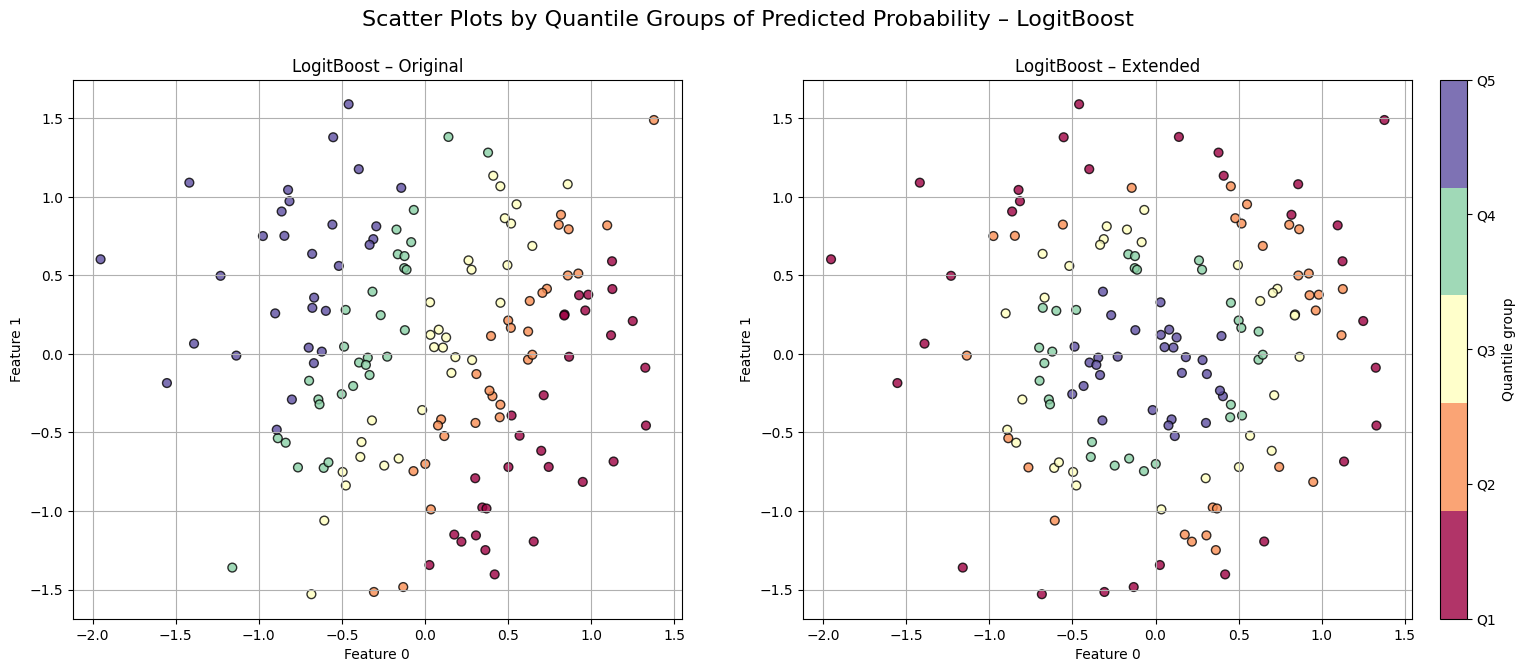

In [16]:
# Get the probabilities of the positive class
y_proba1 = logitboost.logitboost_predict_proba(X_test[:, :2], learners1, J1)[:, 1]
y_proba2 = logitboost.logitboost_predict_proba(X_test,     learners2, J2)[:, 1]

# Define grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Scatter plot for the original model
scatter1 = calibration.plot_scatter_by_quantile(
    X_test[:, :2],
    y_proba1,
    n_quantiles=5,
    title="LogitBoost – Original",
    ax=axes[0],
    cmap="Spectral"
)

# Scatter plot for the extended model
scatter2 = calibration.plot_scatter_by_quantile(
    X_test[:, :2],   # seguimos usando sólo las dos primeras dimensiones
    y_proba2,
    n_quantiles=5,
    title="LogitBoost – Extended",
    ax=axes[1],
    cmap="Spectral"
)

# Color bar
cbar = fig.colorbar(
    scatter2,
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=0.02
)
cbar.set_label("Quantile group")
cbar.set_ticks(range(5))
cbar.set_ticklabels([f"Q{i+1}" for i in range(5)])

fig.suptitle("Scatter Plots by Quantile Groups of Predicted Probability – LogitBoost", fontsize=16)
plt.show()

## Decision trees $C4.5$

Shallow Tree (No Pruning) - Accuracy: 0.6733, AUC: 0.6735, Log Loss: 0.6450
Regular Tree (No Pruning) - Accuracy: 0.7600, AUC: 0.8214, Log Loss: 3.6147
Overfit Tree (No Pruning) - Accuracy: 0.7067, AUC: 0.7068, Log Loss: 10.5728
Regular Tree (With Pruning) - Accuracy: 0.7733, AUC: 0.8142, Log Loss: 2.0681


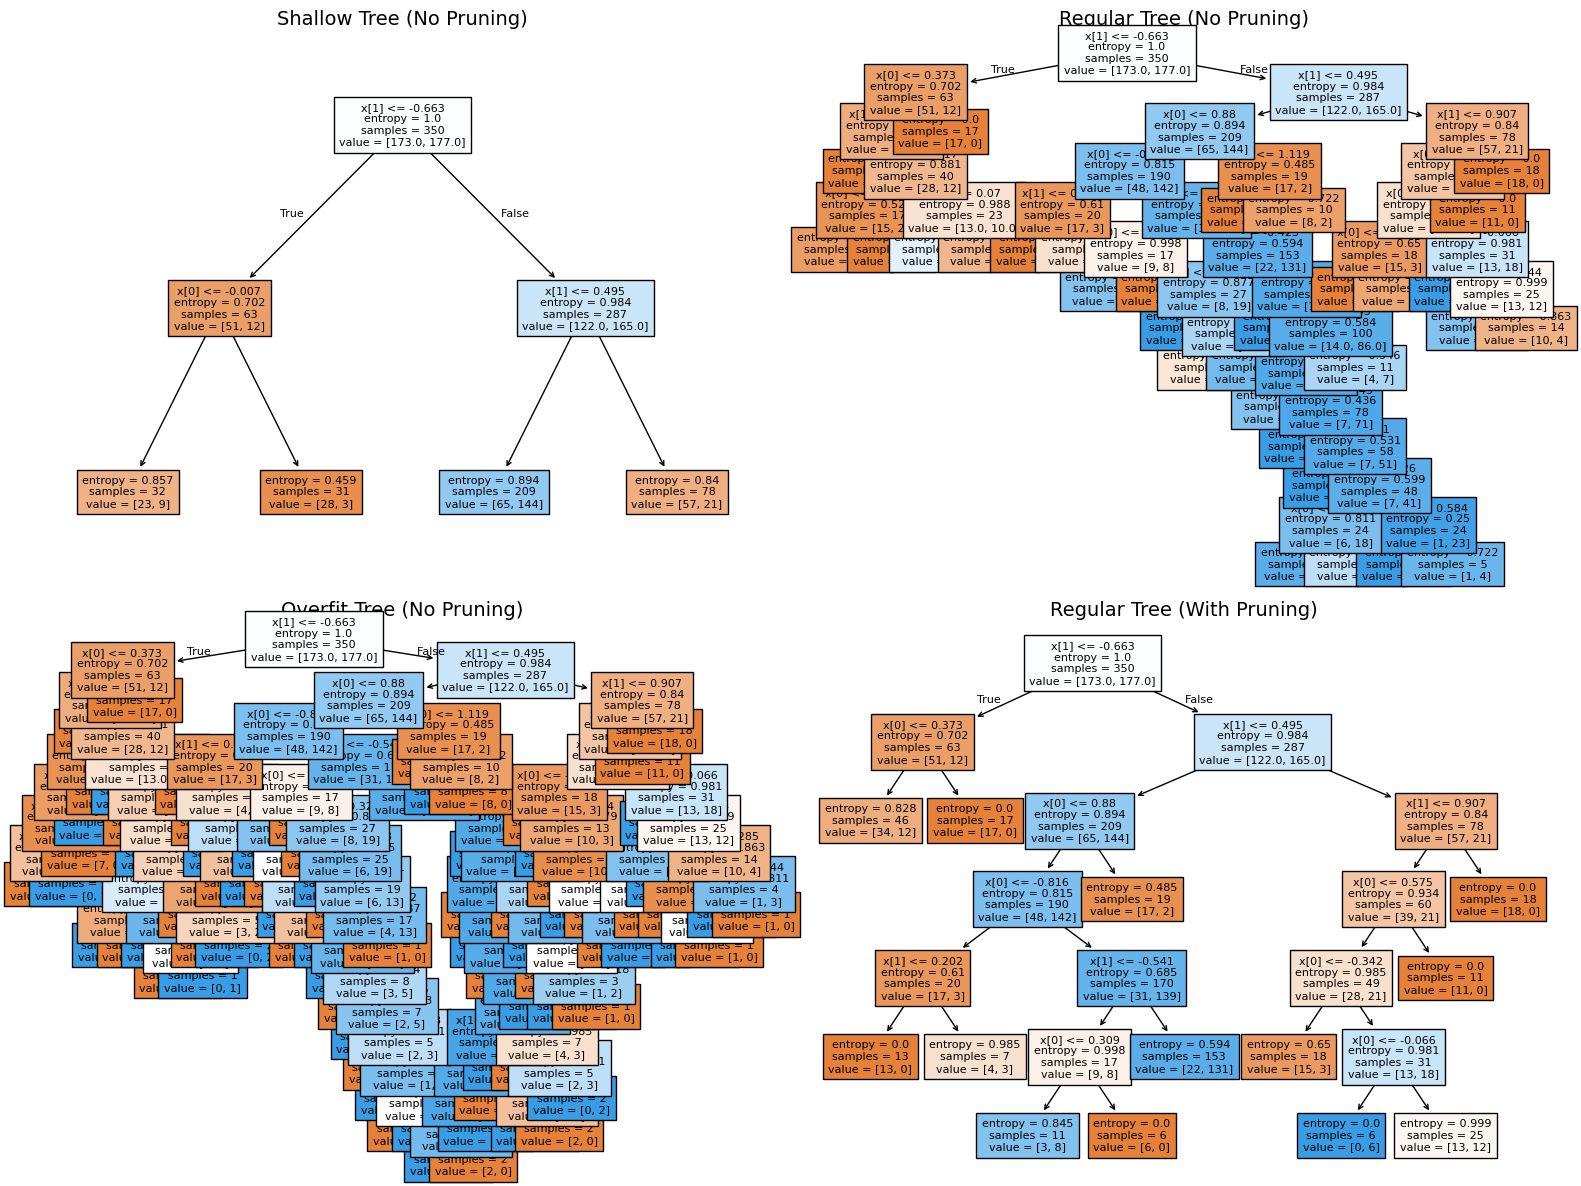

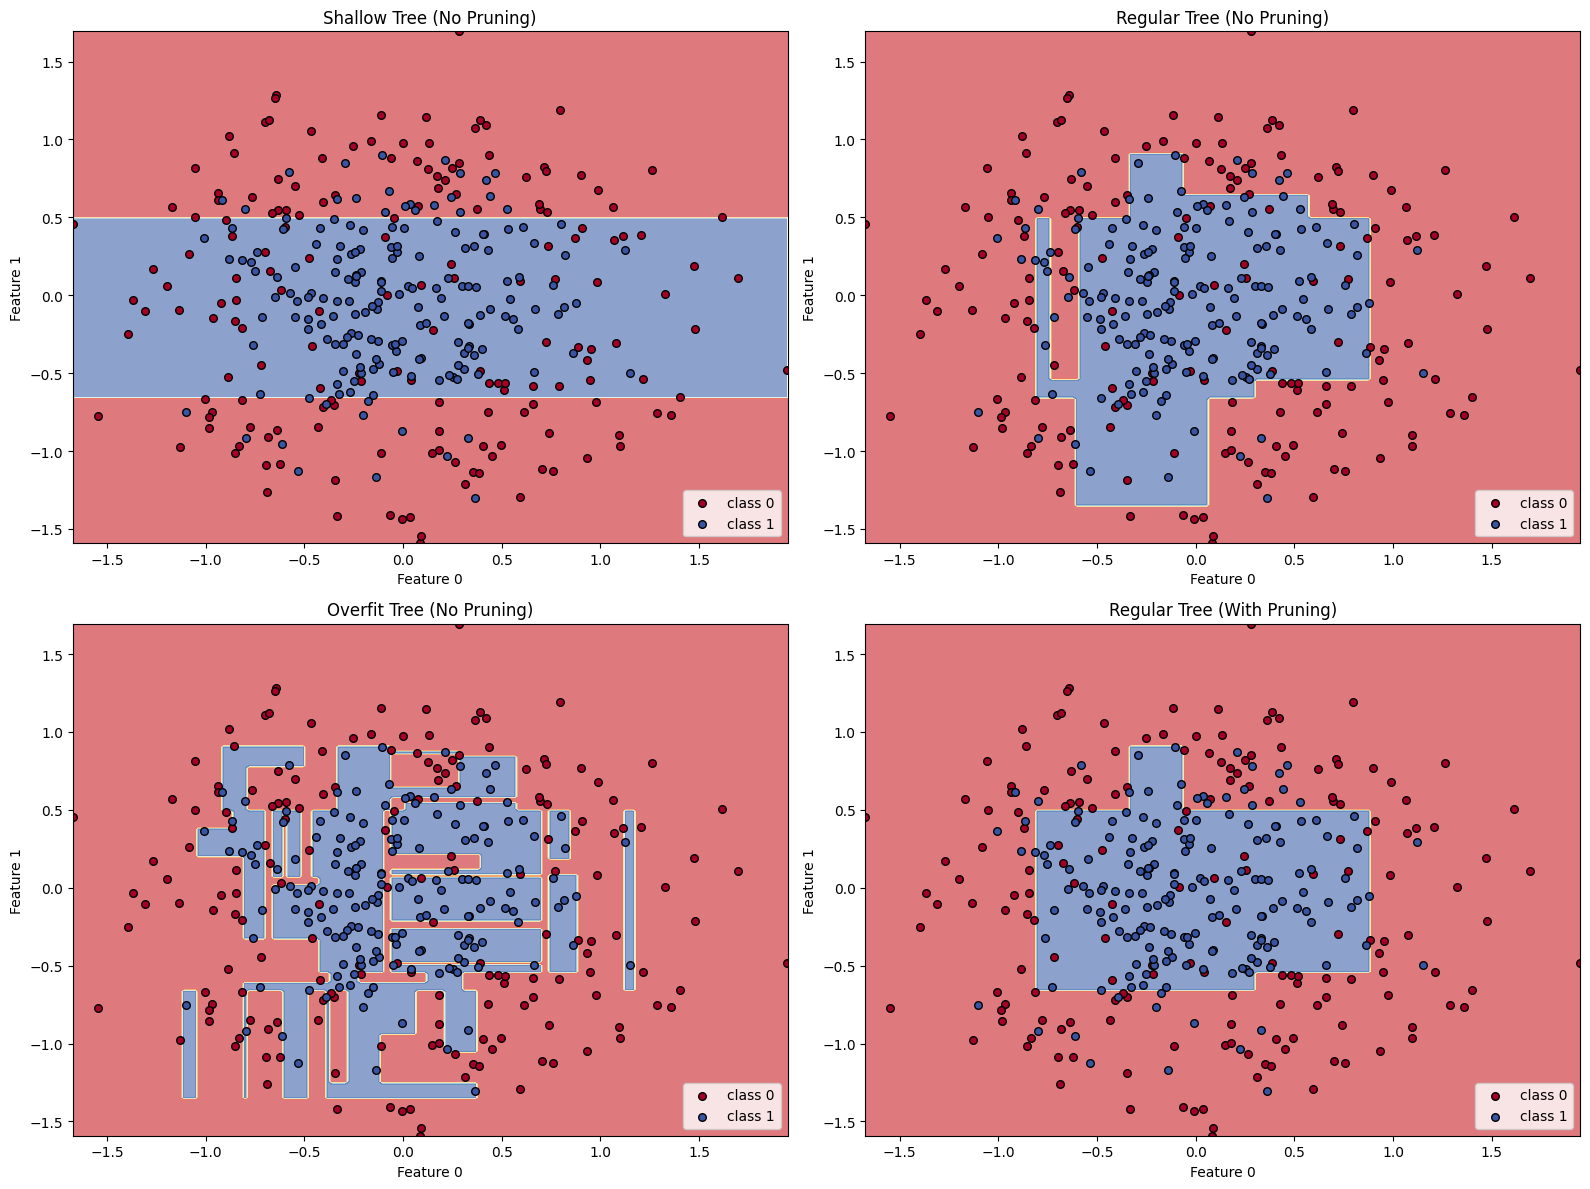

In [17]:
lmt.compare_tree_variants(X_train[:,:2], X_test[:,:2], y_train, y_test, lmt, decision=True)

Shallow Tree (No Pruning) - Accuracy: 0.7533, AUC: 0.8345, Log Loss: 0.4971
Regular Tree (No Pruning) - Accuracy: 0.6733, AUC: 0.7290, Log Loss: 4.4780
Overfit Tree (No Pruning) - Accuracy: 0.6933, AUC: 0.6913, Log Loss: 11.0534
Regular Tree (With Pruning) - Accuracy: 0.7533, AUC: 0.8273, Log Loss: 0.5023


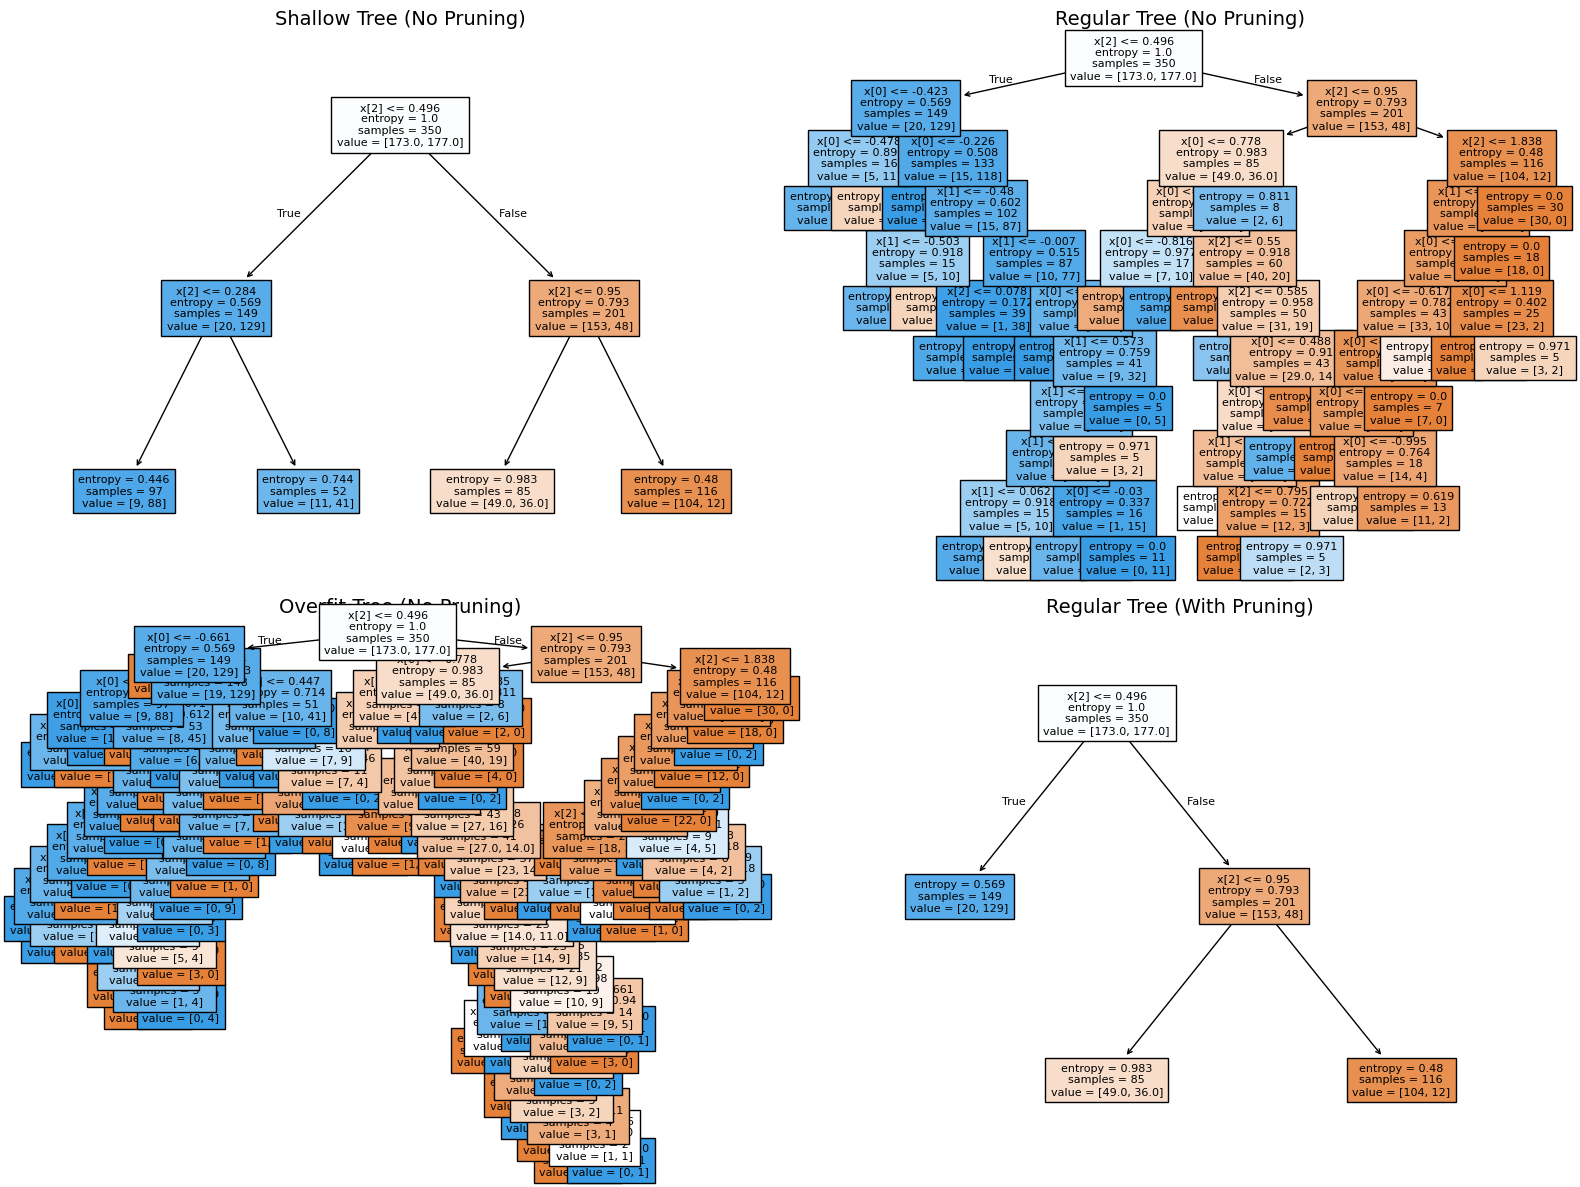

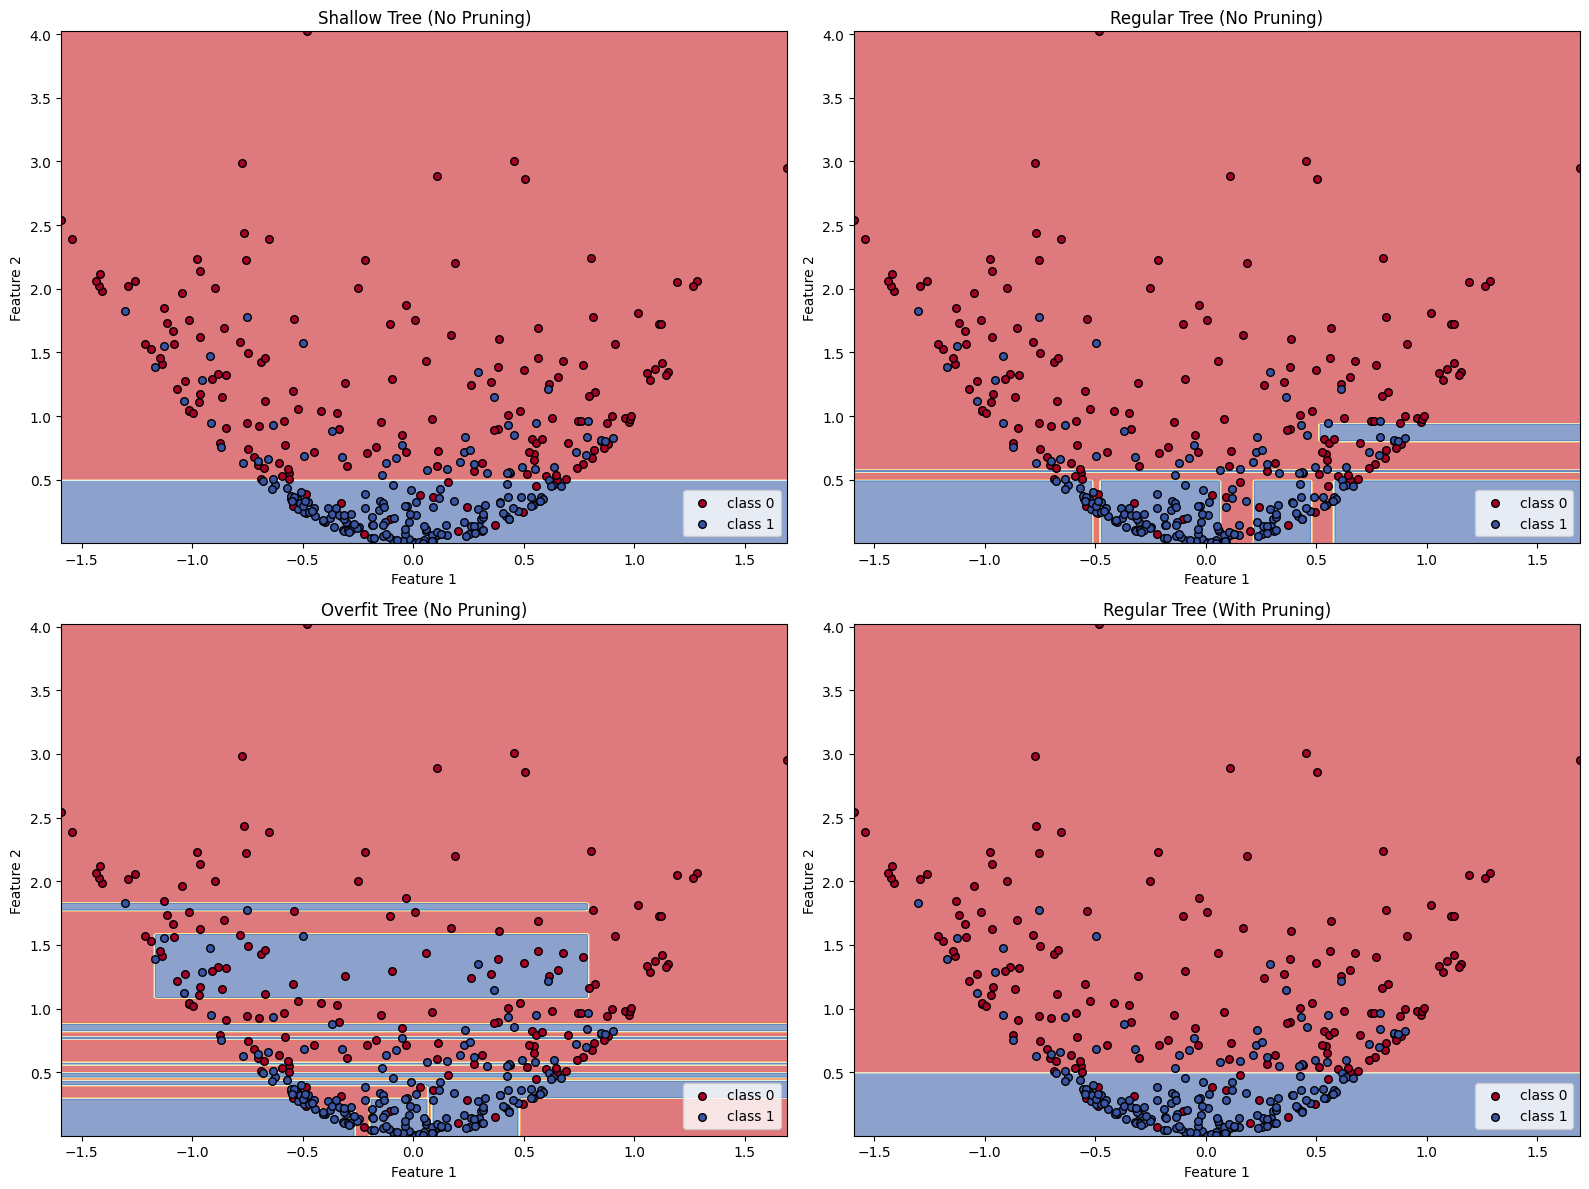

In [18]:
lmt.compare_tree_variants(X_train, X_test, y_train, y_test, lmt, decision=True, feature_pair=(1,2))

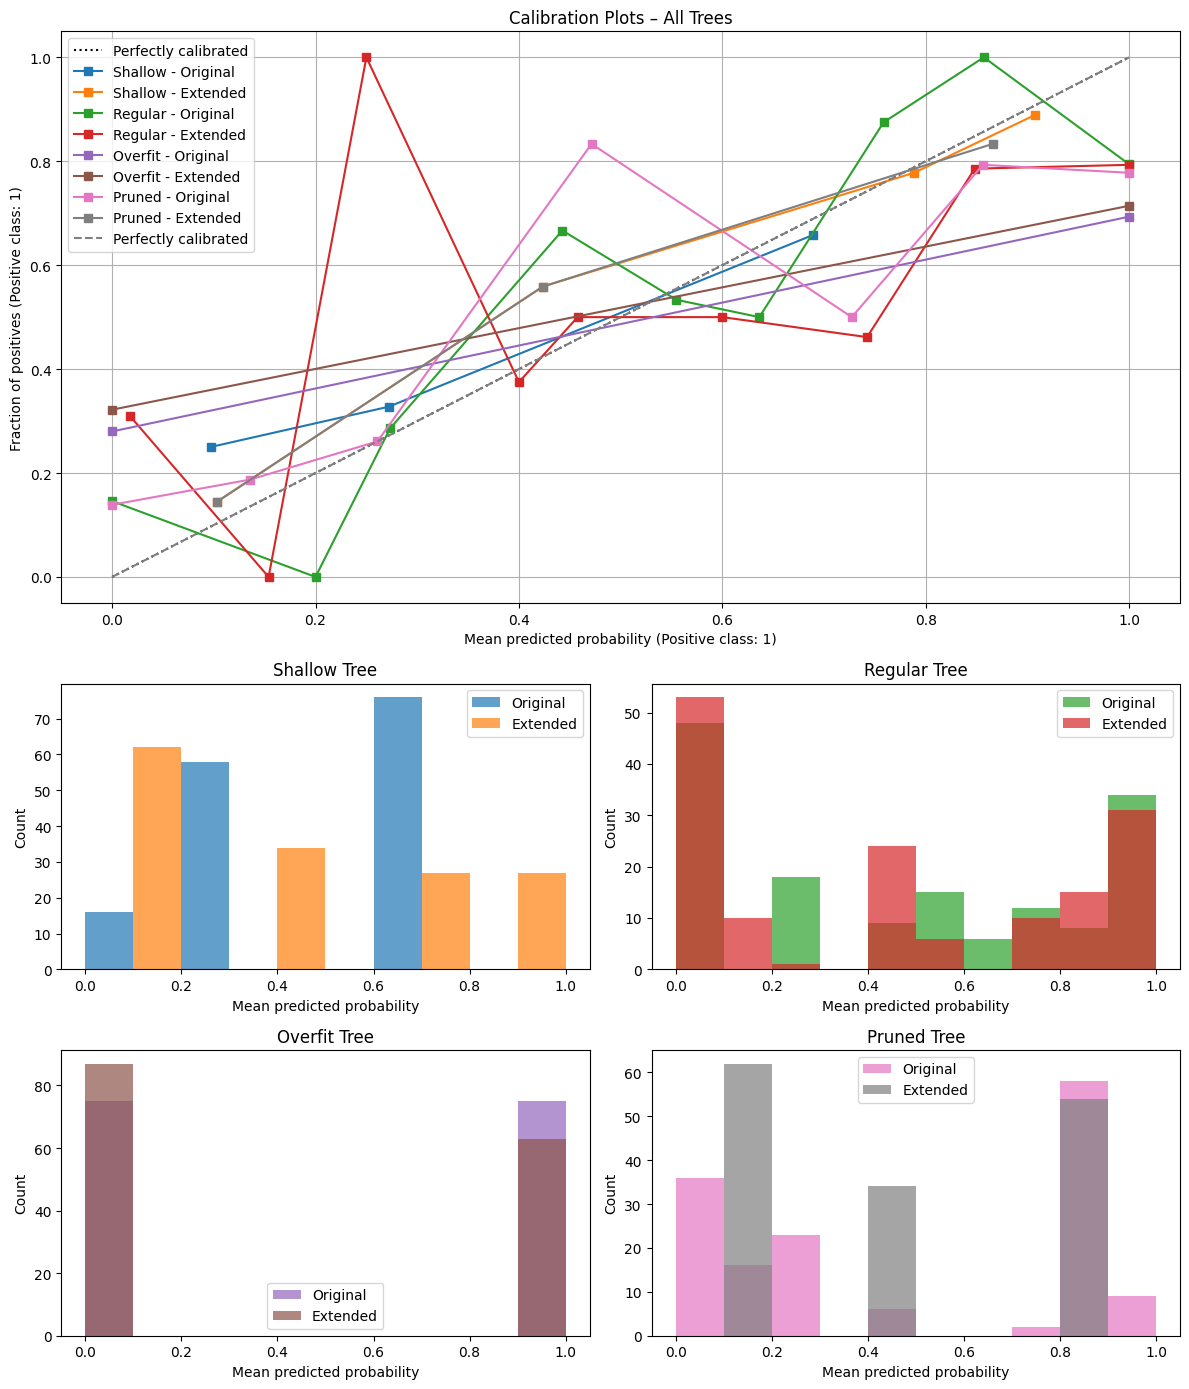

In [19]:
clf_shallow     = lmt.construct_tree(X_train[:,:2],     y_train,     size='shallow', pruning=False)
clf_regular     = lmt.construct_tree(X_train[:,:2],     y_train,     size='regular', pruning=False)
clf_overfit     = lmt.construct_tree(X_train[:,:2],     y_train,     size='overfit', pruning=False)
clf_pruned      = lmt.construct_tree(X_train[:,:2],     y_train,     size='regular', pruning=True)

clf_shallow_ext = lmt.construct_tree(X_train, y_train, size='shallow', pruning=False)
clf_regular_ext = lmt.construct_tree(X_train, y_train, size='regular', pruning=False)
clf_overfit_ext = lmt.construct_tree(X_train, y_train, size='overfit', pruning=False)
clf_pruned_ext  = lmt.construct_tree(X_train, y_train, size='regular', pruning=True)

# Call the plotting function
calibration.plot_combined_calibration_and_hists(
    y_test=y_test,
    X_test=X_test[:, :2],
    y_test_ext=y_test,
    X_test_ext=X_test,
    clf_orig_list=[clf_shallow, clf_regular, clf_overfit, clf_pruned],
    clf_ext_list=[clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext],
)


C:\Users\allis\AppData\Local\Temp\ipykernel_6988\3413240429.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap(cmap_name, nq))


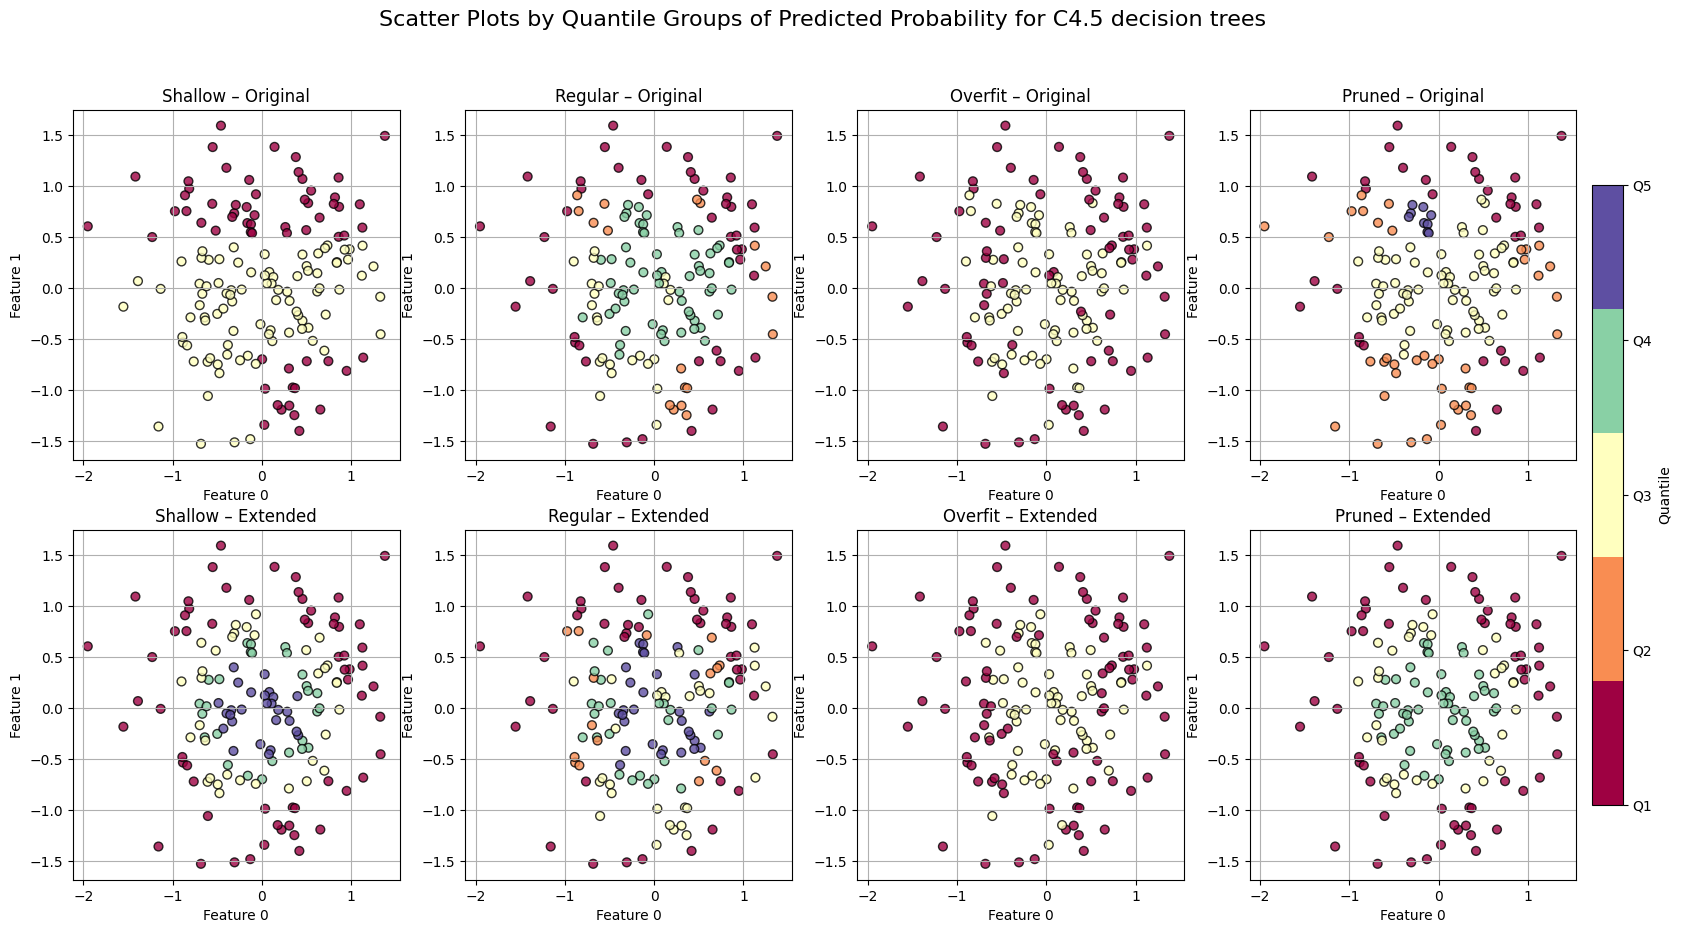

In [20]:
import matplotlib as mpl

nq = 5
norm = mpl.colors.Normalize(vmin=0, vmax=nq-1)
cmap_name = 'Spectral'
model_labels = ["Shallow", "Regular", "Overfit", "Pruned"]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Top row: original (predict on X_test[:,:2])
for idx, clf in enumerate([clf_shallow, clf_regular, clf_overfit, clf_pruned]):
    y_proba = clf.predict_proba(X_test[:, :2])[:, 1]
    X_vis   = X_test[:, :2]
    ax = axes[0, idx]
    sc = calibration.plot_scatter_by_quantile(
        X_vis, y_proba,
        n_quantiles=nq,
        title=f"{model_labels[idx]} – Original",
        ax=ax,
        feature_1=0,
        feature_2=1,
        cmap=cmap_name,
        norm=norm
    )

# Bottom row: extended (predict on full X_test, but still plot [:,:2])
for idx, clf in enumerate([clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext]):
    y_proba = clf.predict_proba(X_test)[:, 1]
    X_vis   = X_test[:, :2]
    ax = axes[1, idx]
    sc = calibration.plot_scatter_by_quantile(
        X_vis, y_proba,
        n_quantiles=nq,
        title=f"{model_labels[idx]} – Extended",
        ax=ax,
        feature_1=0,
        feature_2=1,
        cmap=cmap_name,
        norm=norm
    )

# one shared colorbar via an “empty” ScalarMappable
sm = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap(cmap_name, nq))
sm.set_array([])  # no data needed

cbar = fig.colorbar(
    sm,
    ax=axes,
    orientation='vertical',
    fraction=0.02,
    pad=0.01
)
cbar.set_label("Quantile")
cbar.set_ticks(np.arange(nq))
cbar.set_ticklabels([f"Q{i+1}" for i in range(nq)])

fig.suptitle("Scatter Plots by Quantile Groups of Predicted Probability for C4.5 decision trees", fontsize=16)
plt.show()


## LMT version 1 (*SimpleLogistic* at every node)

Shallow Tree (No Pruning) → Accuracy: 0.5667, AUC: 0.5565, Log Loss: 0.6790
Regular Tree (No Pruning) → Accuracy: 0.5933, AUC: 0.6727, Log Loss: 2.4682
Overfit Tree (No Pruning) → Accuracy: 0.6067, AUC: 0.6945, Log Loss: 6.7960
Regular Tree (With Pruning) → Accuracy: 0.5467, AUC: 0.5417, Log Loss: 1.1321


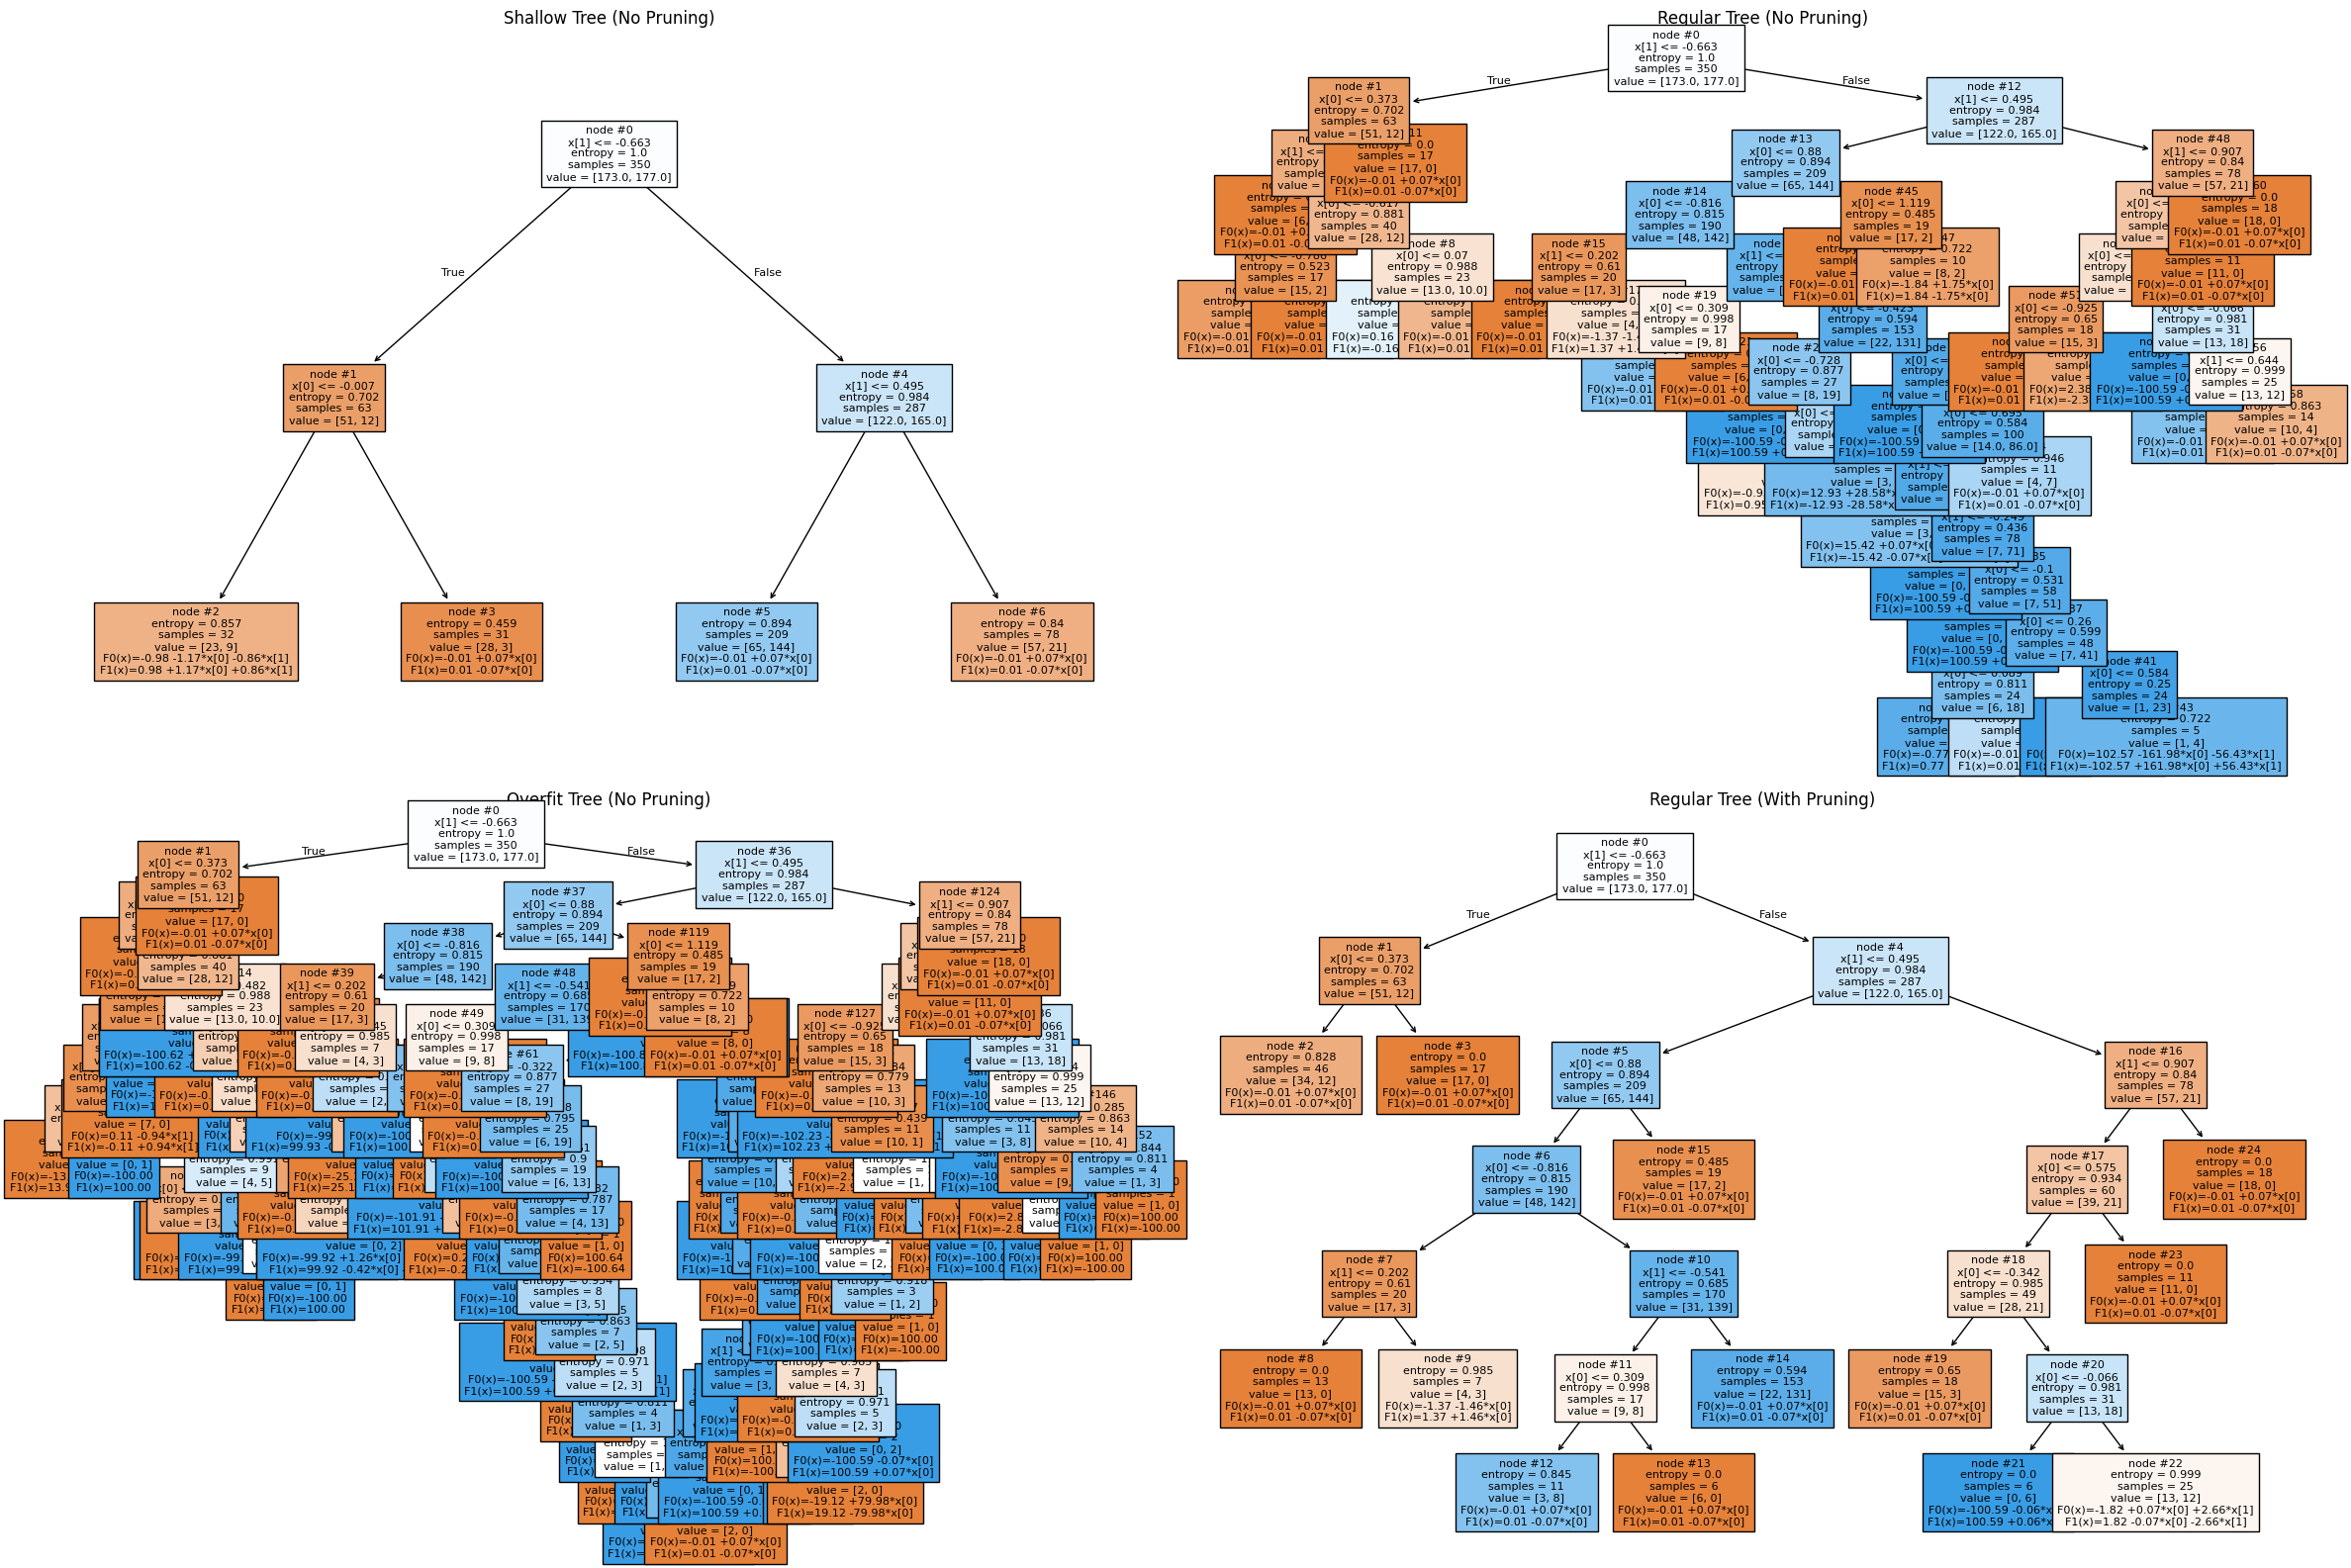

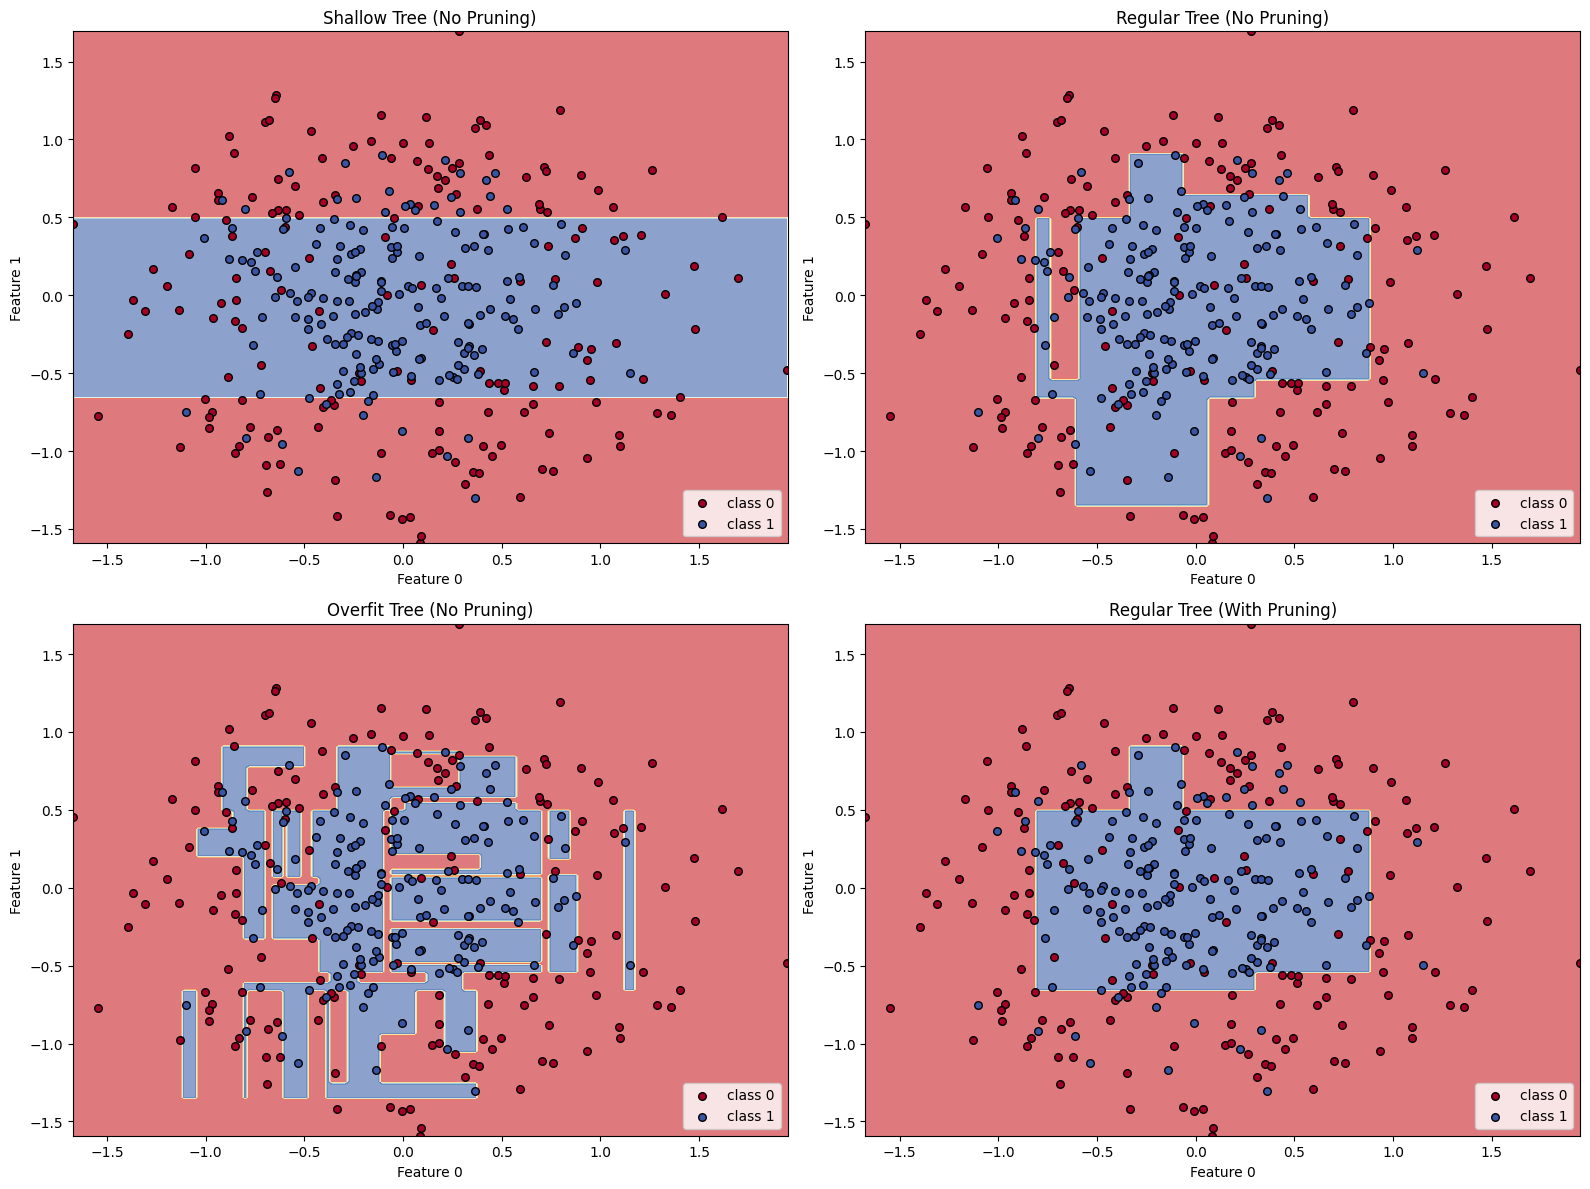

In [17]:
lmt.compare_lmt_variants(X_train[:,:2], X_test[:,:2], y_train, y_test, lmt, decision=True)

Shallow Tree (No Pruning) → Accuracy: 0.7533, AUC: 0.8575, Log Loss: 0.4915
Regular Tree (No Pruning) → Accuracy: 0.7400, AUC: 0.7600, Log Loss: 3.5896
Overfit Tree (No Pruning) → Accuracy: 0.6867, AUC: 0.6728, Log Loss: 6.9958
Regular Tree (With Pruning) → Accuracy: 0.7533, AUC: 0.8575, Log Loss: 0.4915


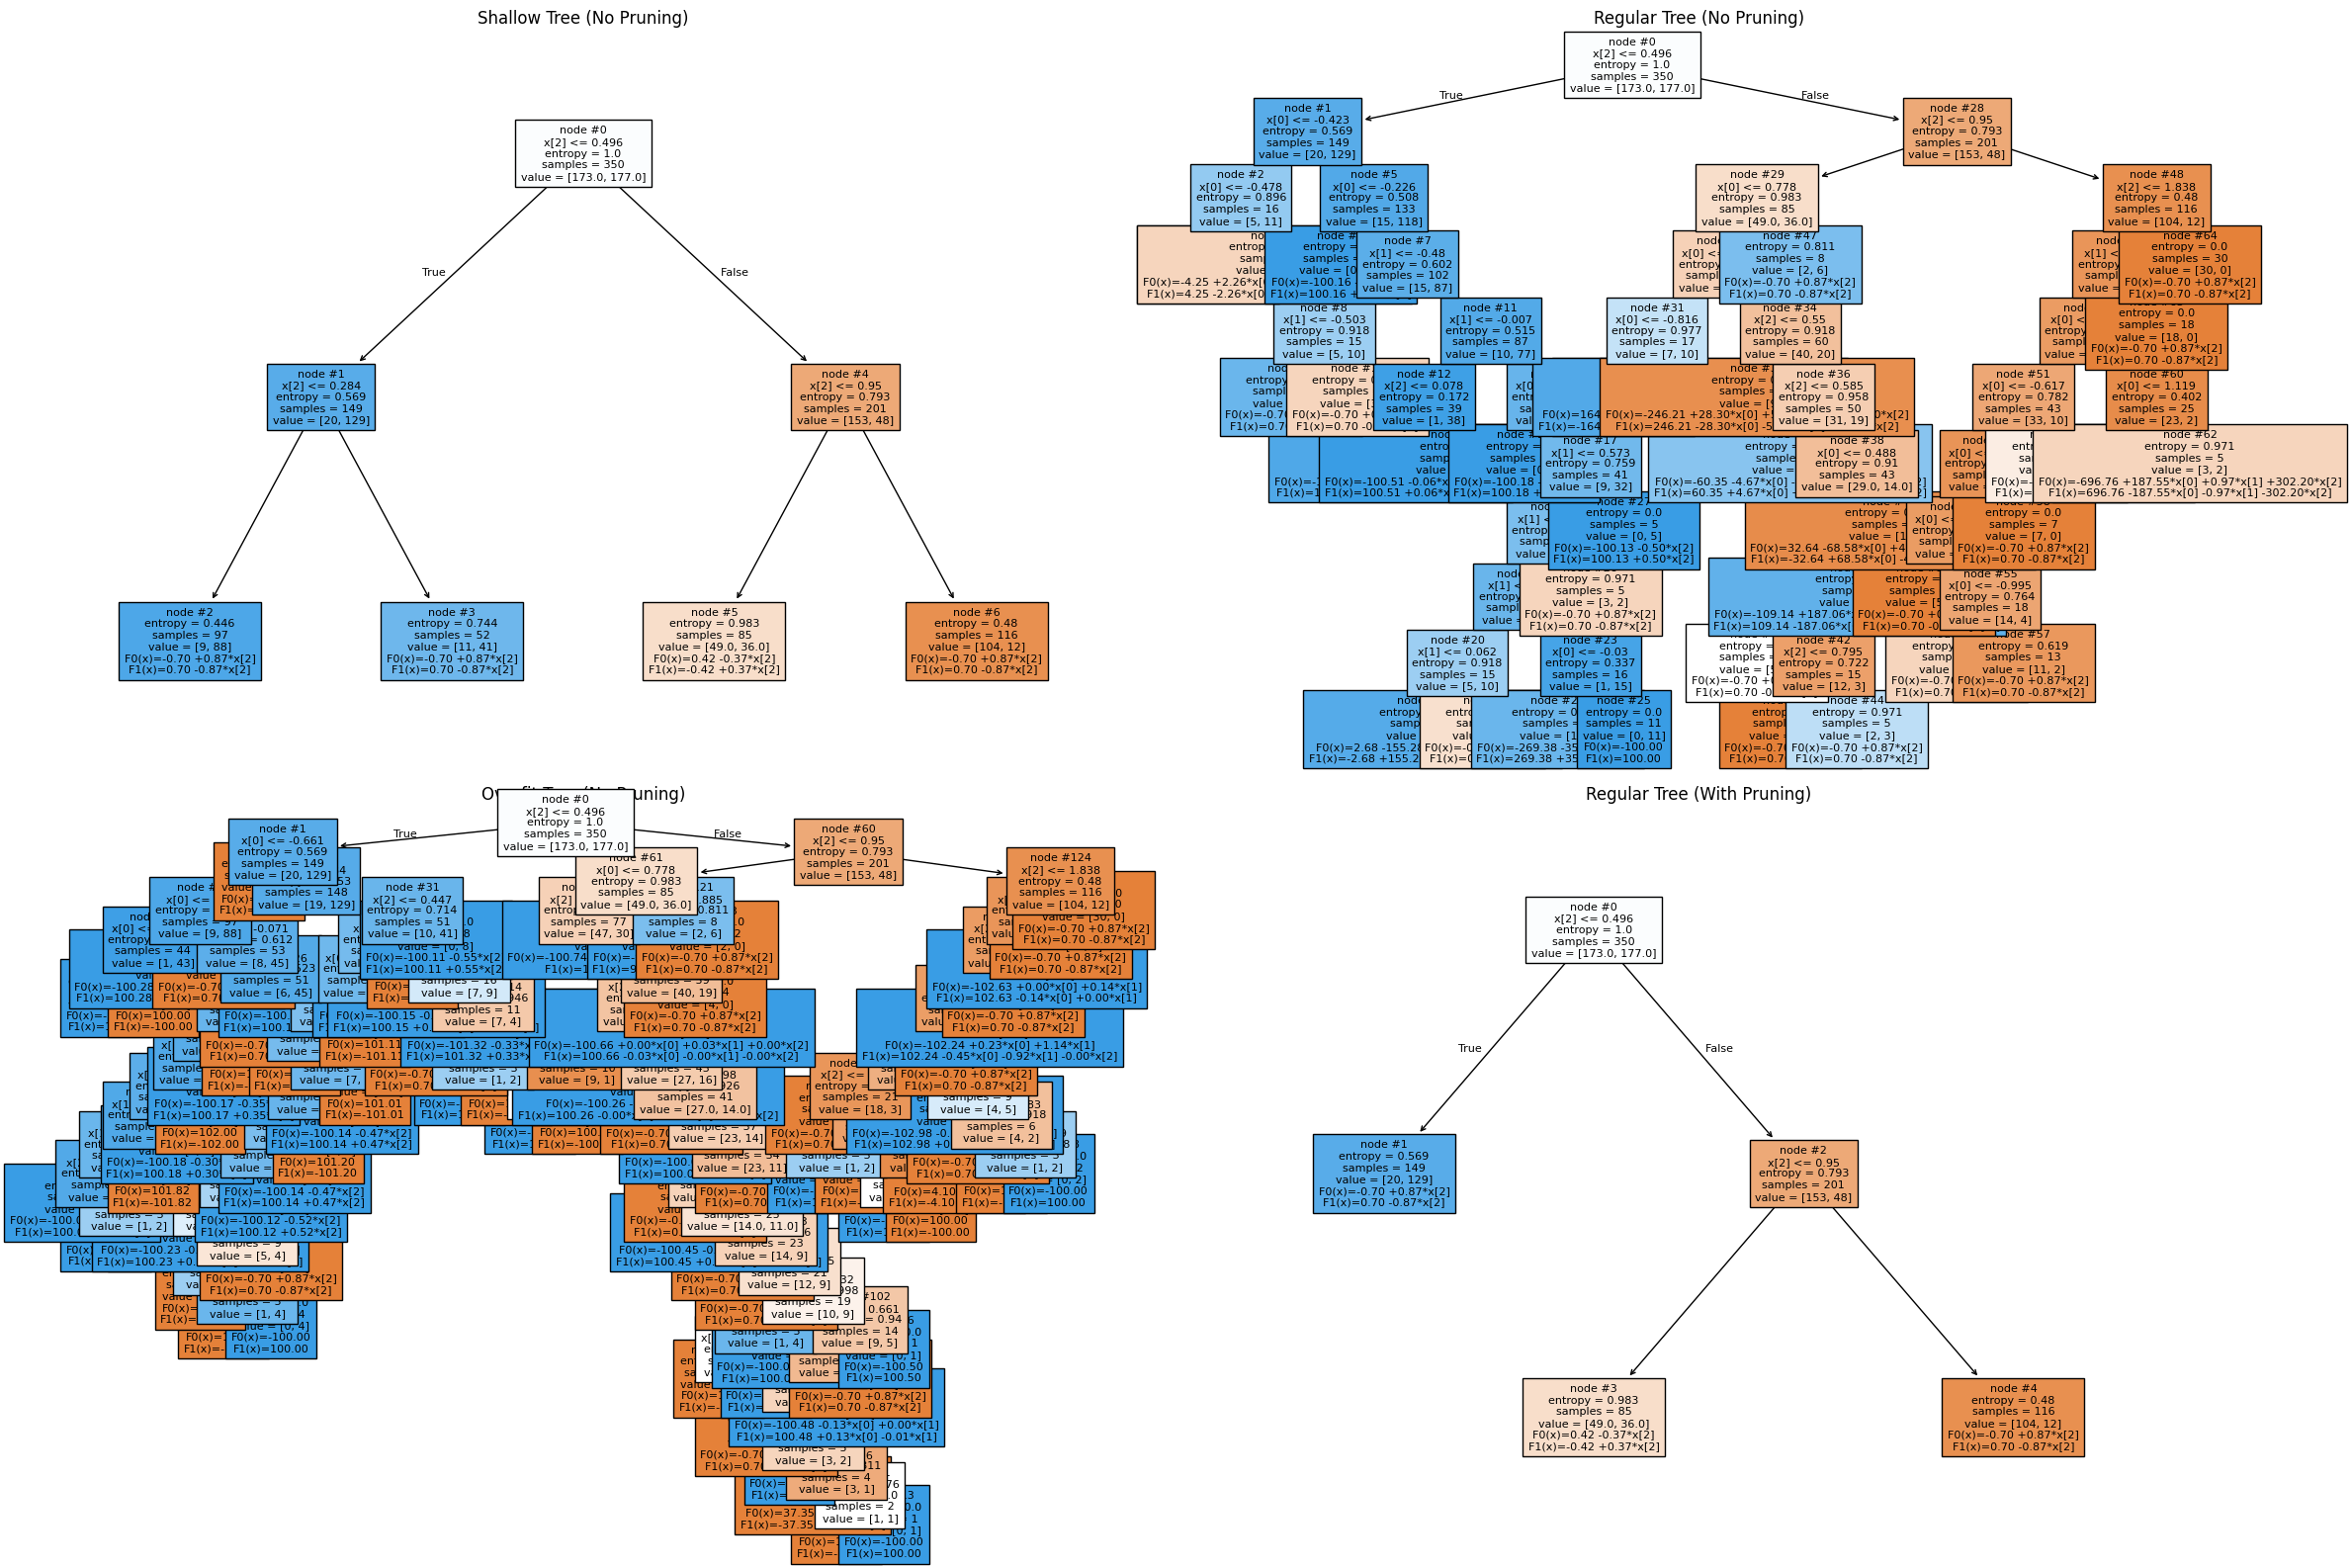

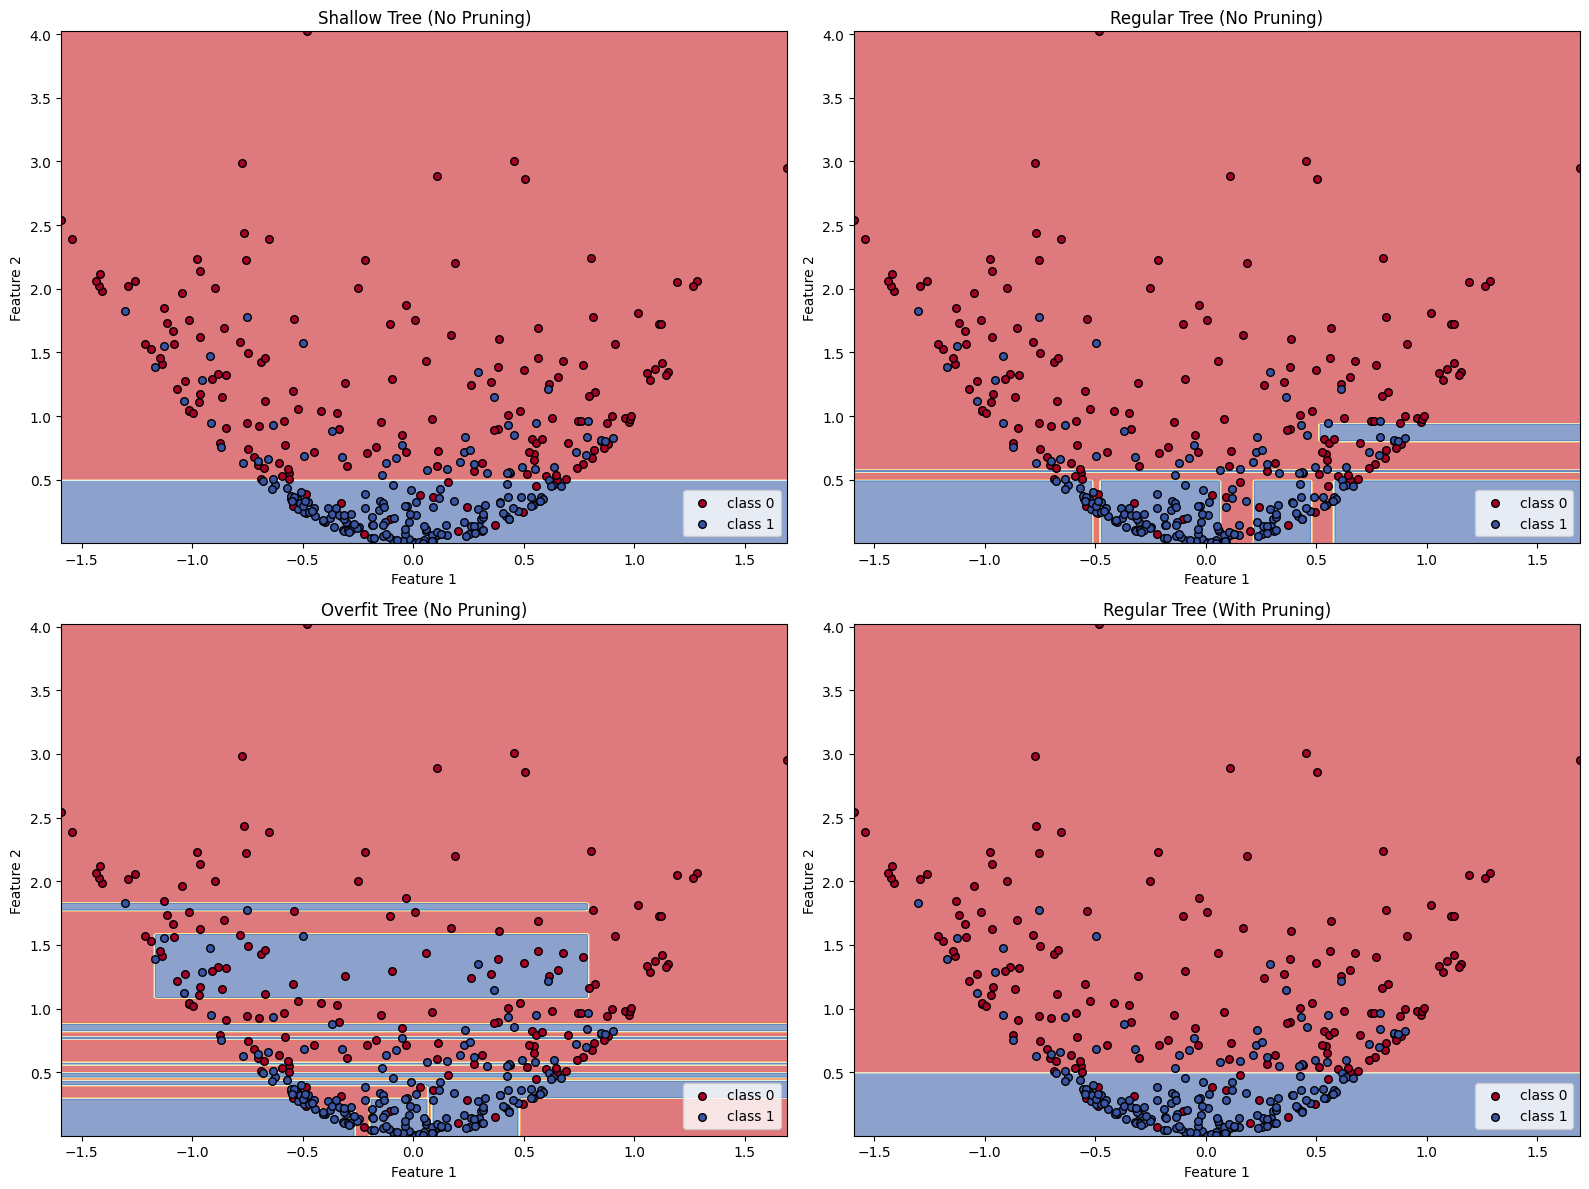

In [18]:
lmt.compare_lmt_variants(X_train, X_test, y_train, y_test, lmt, decision=True, feature_pair=(1,2))

In [8]:
clf_shallow, nodes_shallow     = lmt.fit_logistic_model_tree(X_train[:,:2],     y_train,     size='shallow', pruning=False)
clf_regular, nodes_regular     = lmt.fit_logistic_model_tree(X_train[:,:2],     y_train,     size='regular', pruning=False)
clf_overfit, nodes_overfit     = lmt.fit_logistic_model_tree(X_train[:,:2],     y_train,     size='overfit', pruning=False)
clf_pruned, nodes_pruned      = lmt.fit_logistic_model_tree(X_train[:,:2],     y_train,     size='regular', pruning=True)

clf_shallow_ext, nodes_shallow_ext = lmt.fit_logistic_model_tree(X_train, y_train, size='shallow', pruning=False)
clf_regular_ext, nodes_regular_ext = lmt.fit_logistic_model_tree(X_train, y_train, size='regular', pruning=False)
clf_overfit_ext, nodes_overfit_ext = lmt.fit_logistic_model_tree(X_train, y_train, size='overfit', pruning=False)
clf_pruned_ext, nodes_pruned_ext  = lmt.fit_logistic_model_tree(X_train, y_train, size='regular', pruning=True)

In [20]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_lmt_combined_calibration_and_hists(
    X_test, y_test,
    X_test_ext, y_test_ext,
    clfs, nodes,
    clfs_ext, nodes_ext,
    model_labels=["Shallow", "Regular", "Overfit", "Pruned"],
    n_bins=10
):
    fig = plt.figure(figsize=(12, 14))
    gs = GridSpec(3, 2, figure=fig, height_ratios=[3, 1.5, 1.5])
    
    # Calibration curve plot (top row, spans both columns)
    ax_curve = fig.add_subplot(gs[0, :])
    hist_axes = [fig.add_subplot(gs[i, j]) for i in [1, 2] for j in [0, 1]]

    colors = plt.get_cmap("tab10")

    # Plot all calibration curves in a single axis
    for idx, (clf, node_model, clf_ext, node_model_ext) in enumerate(zip(clfs, nodes, clfs_ext, nodes_ext)):
        proba_orig = lmt.predict_proba_lmt(X_test, clf, node_model)
        proba_ext  = lmt.predict_proba_lmt(X_test_ext, clf_ext, node_model_ext)

        CalibrationDisplay.from_predictions(
            y_test, proba_orig, n_bins=n_bins,
            name=f"{model_labels[idx]} - Original",
            ax=ax_curve, color=colors(2 * idx)
        )
        CalibrationDisplay.from_predictions(
            y_test_ext, proba_ext, n_bins=n_bins,
            name=f"{model_labels[idx]} - Extended",
            ax=ax_curve, color=colors(2 * idx + 1)
        )

    ax_curve.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    ax_curve.set_title("Calibration Plots – All Trees")
    ax_curve.set_xlabel("Mean predicted probability (Positive class: 1)")
    ax_curve.set_ylabel("Fraction of positives (Positive class: 1)")
    ax_curve.legend(loc='best')
    ax_curve.grid(True)

    # Plot individual histograms
    for idx, (clf, node_model, clf_ext, node_model_ext) in enumerate(zip(clfs, nodes, clfs_ext, nodes_ext)):
        ax = hist_axes[idx]
        proba_orig = lmt.predict_proba_lmt(X_test, clf, node_model)
        proba_ext  = lmt.predict_proba_lmt(X_test_ext, clf_ext, node_model_ext)

        ax.hist(proba_orig, bins=n_bins, range=(0, 1), alpha=0.7, color=colors(2 * idx), label="Original")
        ax.hist(proba_ext, bins=n_bins, range=(0, 1), alpha=0.7, color=colors(2 * idx + 1), label="Extended")
        ax.set_title(f"{model_labels[idx]} Tree")
        ax.set_xlabel("Mean predicted probability")
        ax.set_ylabel("Count")
        ax.legend()

    fig.tight_layout()
    plt.show()


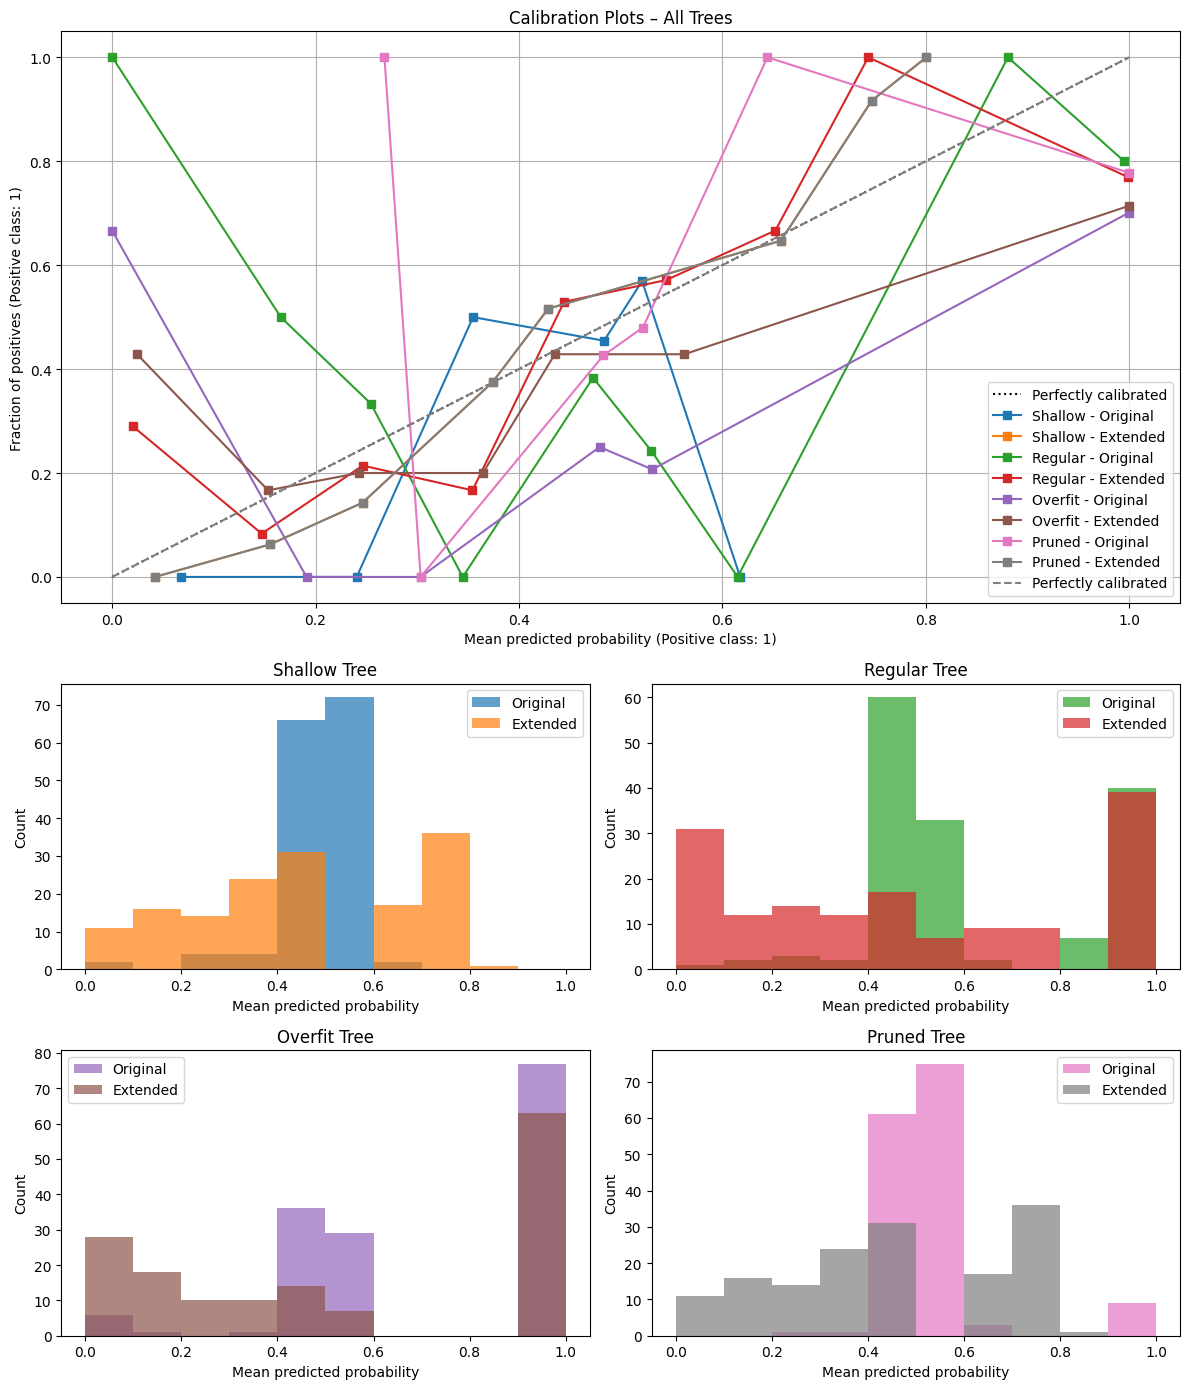

In [ ]:
# Call the plotting function
lmt.plot_lmt_combined_calibration_and_hists(
    X_test[:,:2], y_test,
    X_test, y_test,
    clfs=[clf_shallow, clf_regular, clf_overfit, clf_pruned],
    nodes=[nodes_shallow, nodes_regular, nodes_overfit, nodes_pruned],
    clfs_ext=[clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext],
    nodes_ext=[nodes_shallow_ext, nodes_regular_ext, nodes_overfit_ext, nodes_pruned_ext],
    model_labels=["Shallow", "Regular", "Overfit", "Pruned"]
)

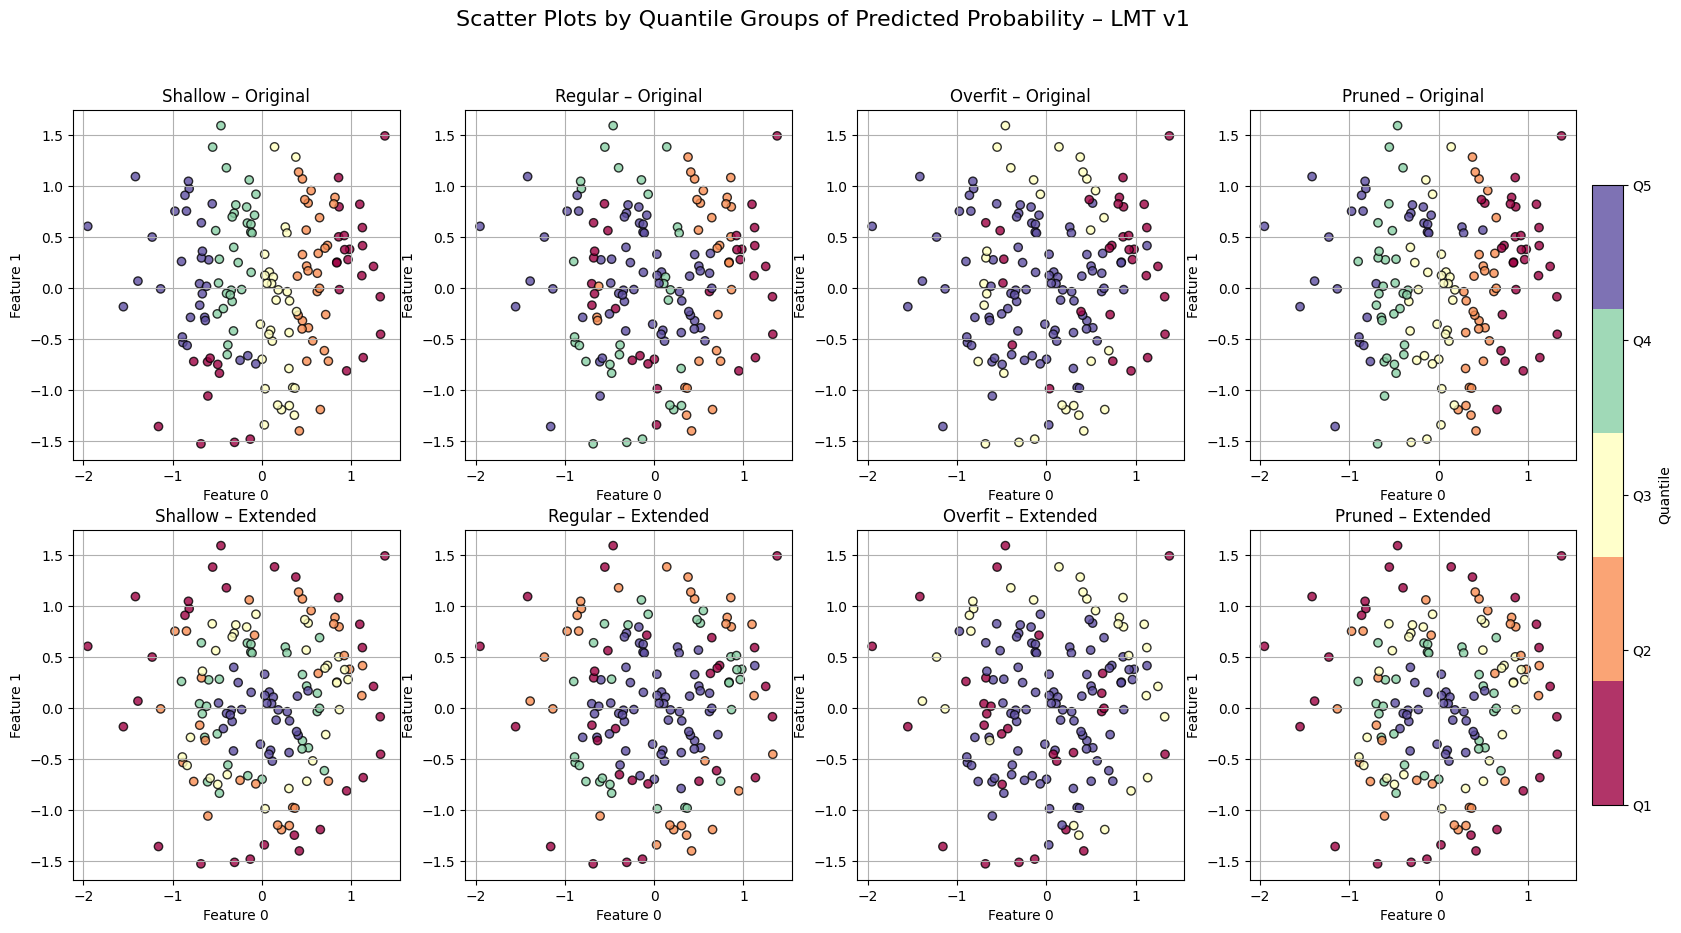

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
model_labels = ["Shallow", "Regular", "Overfit", "Pruned"]

# Top row – Original LMT models
for idx, (clf, node_model) in enumerate(zip(
    [clf_shallow, clf_regular, clf_overfit, clf_pruned],
    [nodes_shallow, nodes_regular, nodes_overfit, nodes_pruned]
)):
    y_proba = lmt.predict_proba_lmt(X_test[:, :2], clf, node_model)
    X_vis = X_test[:, :2]
    ax = axes[0, idx]
    scatter = calibration.plot_scatter_by_quantile(
        X_vis, y_proba, n_quantiles=5,
        title=f"{model_labels[idx]} – Original",
        ax=ax,
        cmap='Spectral'
    )

# Bottom row – Extended LMT models
for idx, (clf, node_model) in enumerate(zip(
    [clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext],
    [nodes_shallow_ext, nodes_regular_ext, nodes_overfit_ext, nodes_pruned_ext]
)):
    y_proba = lmt.predict_proba_lmt(X_test, clf, node_model)
    X_vis = X_test[:, :2]
    ax = axes[1, idx]
    scatter = calibration.plot_scatter_by_quantile(
        X_vis, y_proba, n_quantiles=5,
        title=f"{model_labels[idx]} – Extended",
        ax=ax,
        cmap='Spectral'
    )

# Add shared colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Quantile")
cbar.set_ticks(range(5))
cbar.set_ticklabels([f"Q{i+1}" for i in range(5)])

fig.suptitle("Scatter Plots by Quantile Groups of Predicted Probability – LMT v1", fontsize=16)
plt.show()


## LMT version 2 (*SimpleLogistic* just at the root node)

In [15]:
def compare_lmt_variants_v2(X_train, X_test, y_train, y_test, lmt, decision=True, feature_pair=(0,1)):
    """
    Trains and evaluates four logistic model trees using different sizes and pruning strategies.
    Plots the tree structure and prints evaluation metrics.
    
    Parameters
    ----------
    X_train, X_test : pd.DataFrame or np.ndarray
        Training and test feature sets.
    y_train, y_test : pd.Series or np.ndarray
        Training and test labels.
    lmt : module or object
        Module or object that provides the `construct_tree` method.
    """
    
    configs = [
        ('shallow', False, "Shallow Tree (No Pruning)"),
        ('regular', False, "Regular Tree (No Pruning)"),
        ('overfit', False, "Overfit Tree (No Pruning)"),
        ('regular', True,  "Regular Tree (With Pruning)")
    ]

    fitted = []

    # Tree construction
    for size, pruning, label in configs:
        clf_tree, node_models = lmt.fit_logistic_model_tree_v2(X_train, y_train, size=size, pruning=pruning)
        #print(node_models)
        # Hard predictions
        y_pred = lmt.predict_lmt(X_test, clf_tree, node_models)
        # 3) extract per‐sample proba. of class 1
        y_prob = lmt.predict_proba_lmt(X_test, clf_tree, node_models)

        # 4) metrics
        acc  = accuracy_score(y_test, y_pred)
        auc  = roc_auc_score(y_test, y_prob)
        loss = log_loss(y_test, y_prob)
        print(f"{label} → Accuracy: {acc:.4f}, AUC: {auc:.4f}, Log Loss: {loss:.4f}")
        
        fitted.append((clf_tree, node_models, label))

    # Plotting all four trees
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))
    axes = axes.flatten()

    # Plotting all four trees
    for i, (clf_tree, node_models, label) in enumerate(fitted):
        lmt.plot_tree_with_linear_models(
            clf_tree=clf_tree,
            node_models=node_models,
            X=X_train,
            title=label,
            ax=axes[i]  # Use subplot axis
        )

    if decision:
        # Plotting decision surfaces of all four trees
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        for ax, (clf_tree, _, label) in zip(axes.ravel(), fitted):
            lmt.plot_decision_surface_from_fitted_tree(
                clf_tree=clf_tree,
                X=X_train,
                feature_pair=feature_pair,
                y=y_train,
                fixed_vals=None,
                grid_steps=200,
                cmap='RdYlBu',
                ax=ax,
                title=label
            )
        plt.tight_layout()
        plt.show()

Shallow Tree (No Pruning) → Accuracy: 0.6733, AUC: 0.6952, Log Loss: 0.6334
Regular Tree (No Pruning) → Accuracy: 0.7333, AUC: 0.7774, Log Loss: 1.5907
Overfit Tree (No Pruning) → Accuracy: 0.7067, AUC: 0.7033, Log Loss: 1.5334
Regular Tree (With Pruning) → Accuracy: 0.7333, AUC: 0.7536, Log Loss: 0.6649


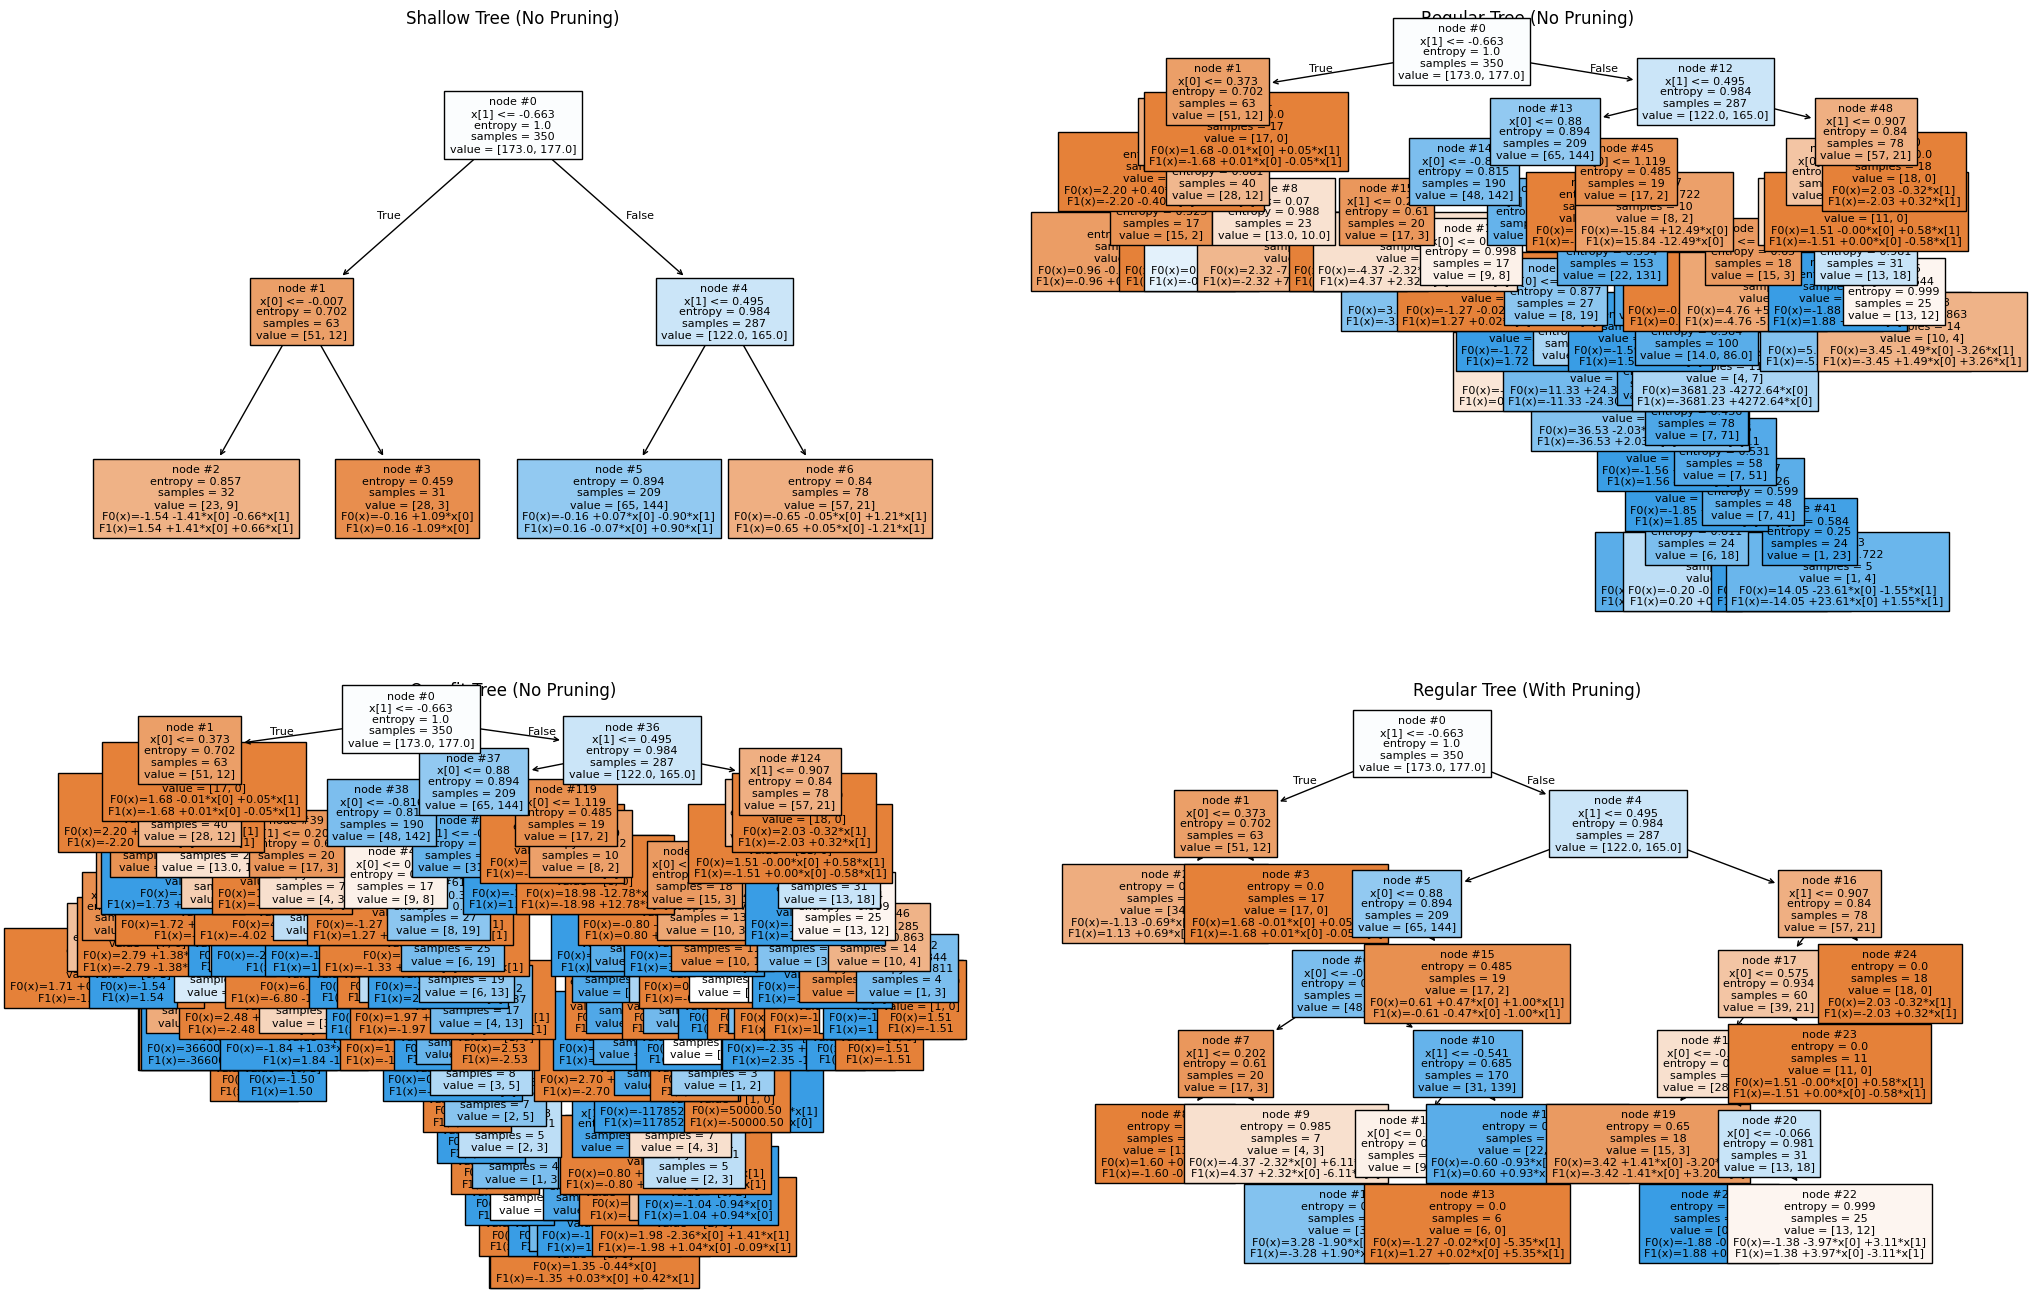

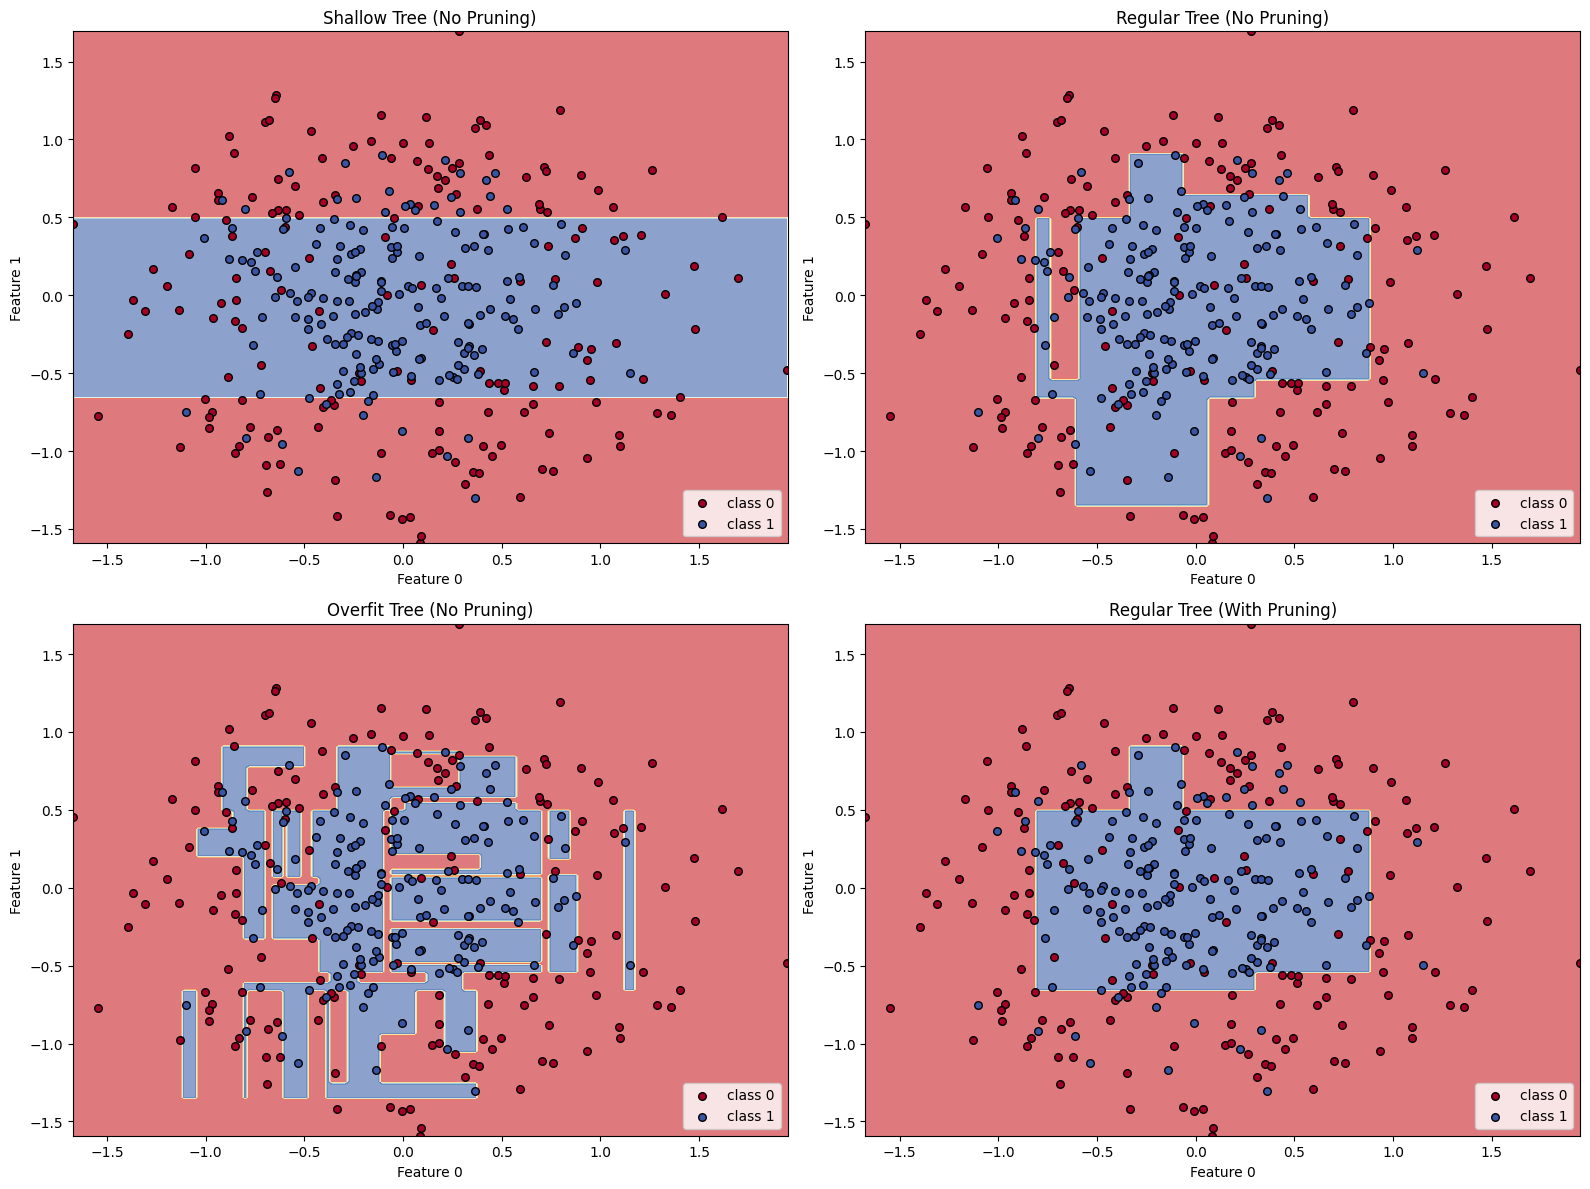

In [17]:
compare_lmt_variants_v2(X_train[:,:2], X_test[:,:2], y_train, y_test, lmt, decision=True)

Shallow Tree (No Pruning) → Accuracy: 0.7800, AUC: 0.8449, Log Loss: 0.4873
Regular Tree (No Pruning) → Accuracy: 0.6933, AUC: 0.7057, Log Loss: 0.9720
Overfit Tree (No Pruning) → Accuracy: 0.6933, AUC: 0.6740, Log Loss: 1.2751
Regular Tree (With Pruning) → Accuracy: 0.7800, AUC: 0.8481, Log Loss: 0.5101


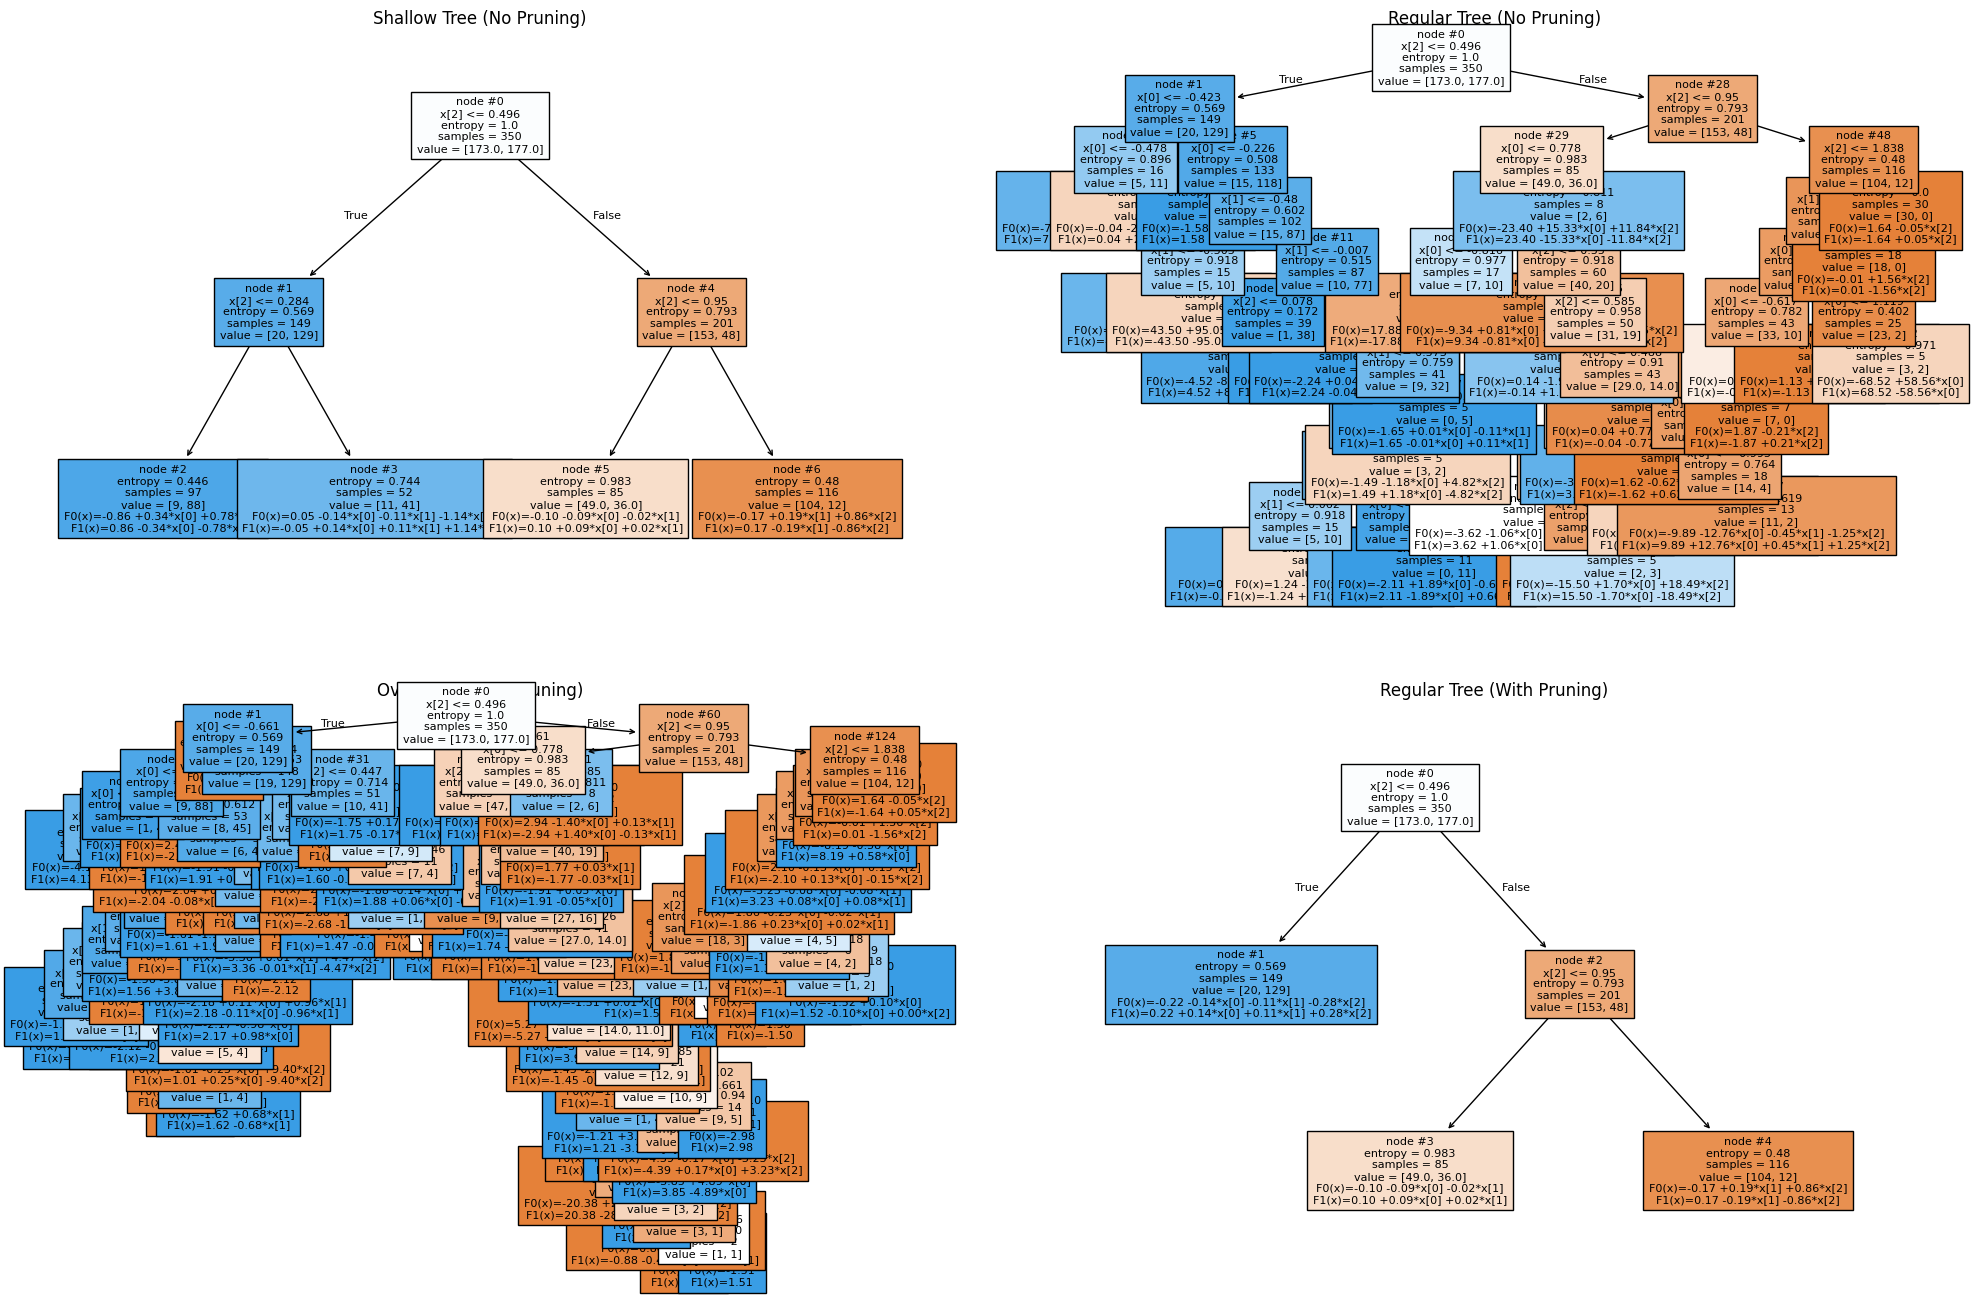

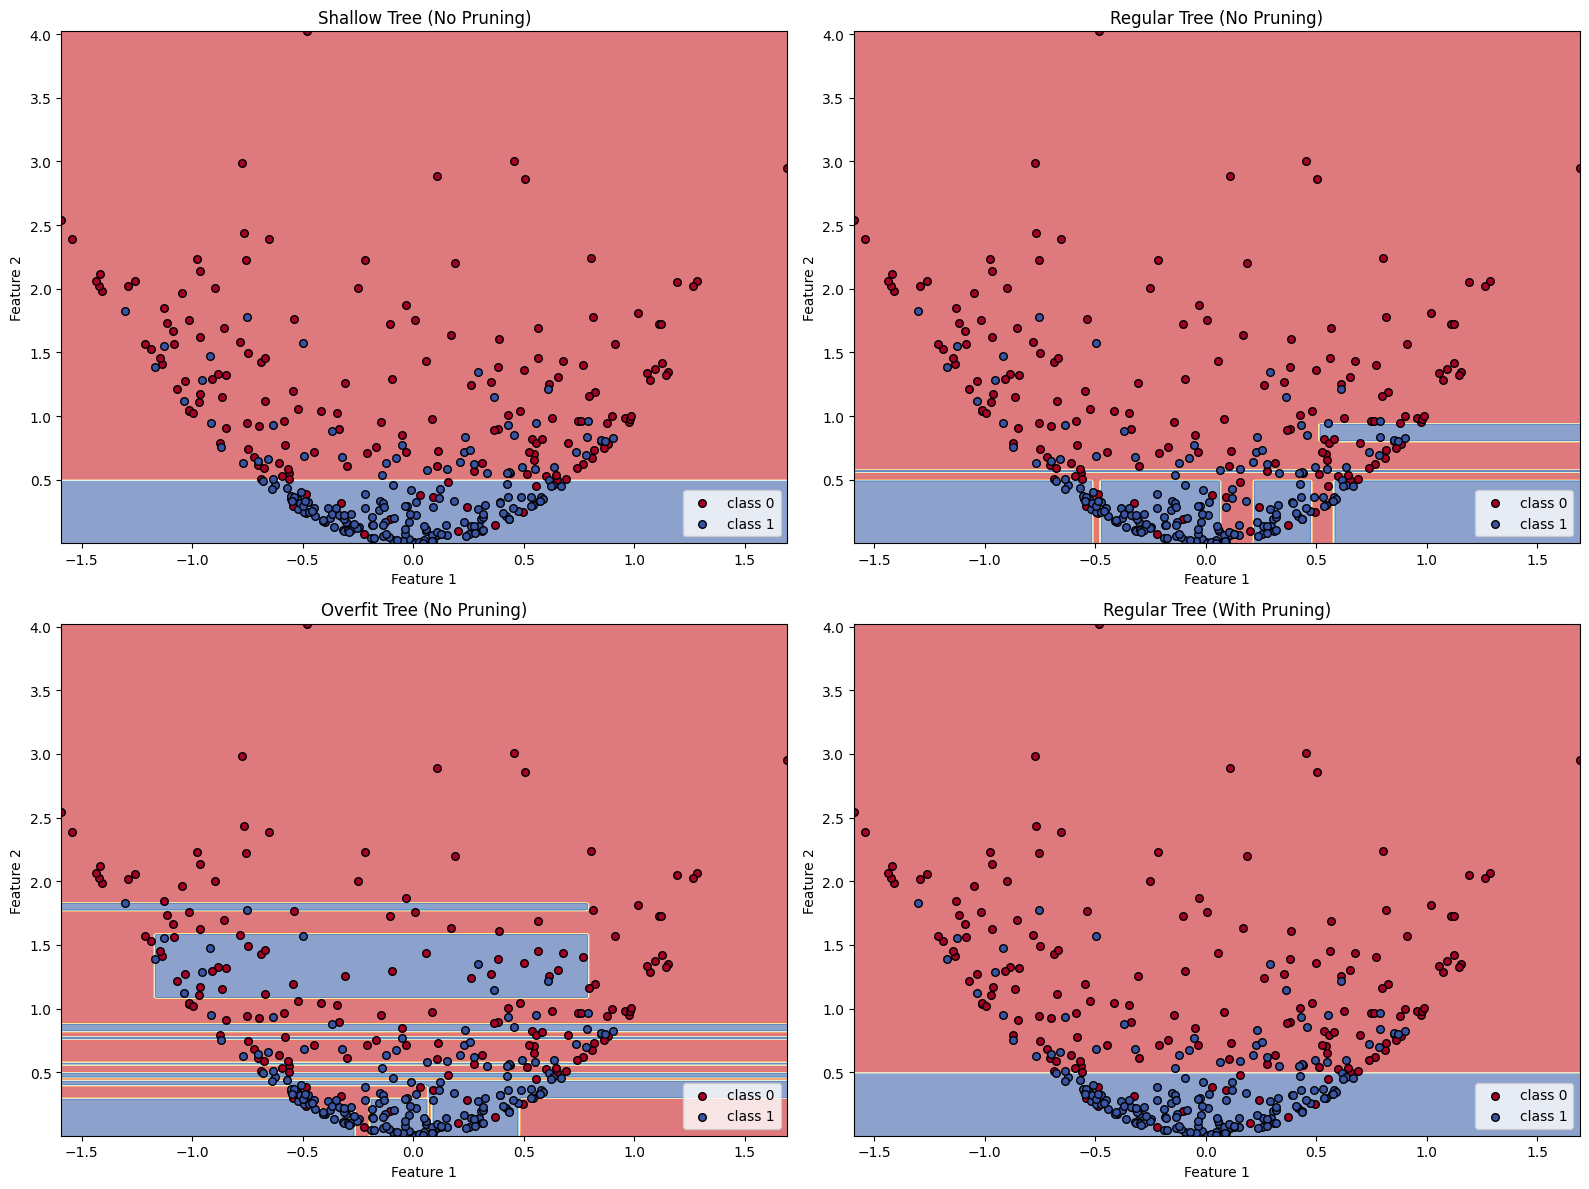

In [18]:
compare_lmt_variants_v2(X_train, X_test, y_train, y_test, lmt, decision=True, feature_pair=(1,2))

In [19]:
clf_shallow2, nodes_shallow2     = lmt.fit_logistic_model_tree_v2(X_train[:,:2],     y_train,     size='shallow', pruning=False)
clf_regular2, nodes_regular2     = lmt.fit_logistic_model_tree_v2(X_train[:,:2],     y_train,     size='regular', pruning=False)
clf_overfit2, nodes_overfit2     = lmt.fit_logistic_model_tree_v2(X_train[:,:2],     y_train,     size='overfit', pruning=False)
clf_pruned2, nodes_pruned2      = lmt.fit_logistic_model_tree_v2(X_train[:,:2],     y_train,     size='regular', pruning=True)

clf_shallow_ext2, nodes_shallow_ext2 = lmt.fit_logistic_model_tree_v2(X_train, y_train, size='shallow', pruning=False)
clf_regular_ext2, nodes_regular_ext2 = lmt.fit_logistic_model_tree_v2(X_train, y_train, size='regular', pruning=False)
clf_overfit_ext2, nodes_overfit_ext2 = lmt.fit_logistic_model_tree_v2(X_train, y_train, size='overfit', pruning=False)
clf_pruned_ext2, nodes_pruned_ext2  = lmt.fit_logistic_model_tree_v2(X_train, y_train, size='regular', pruning=True)

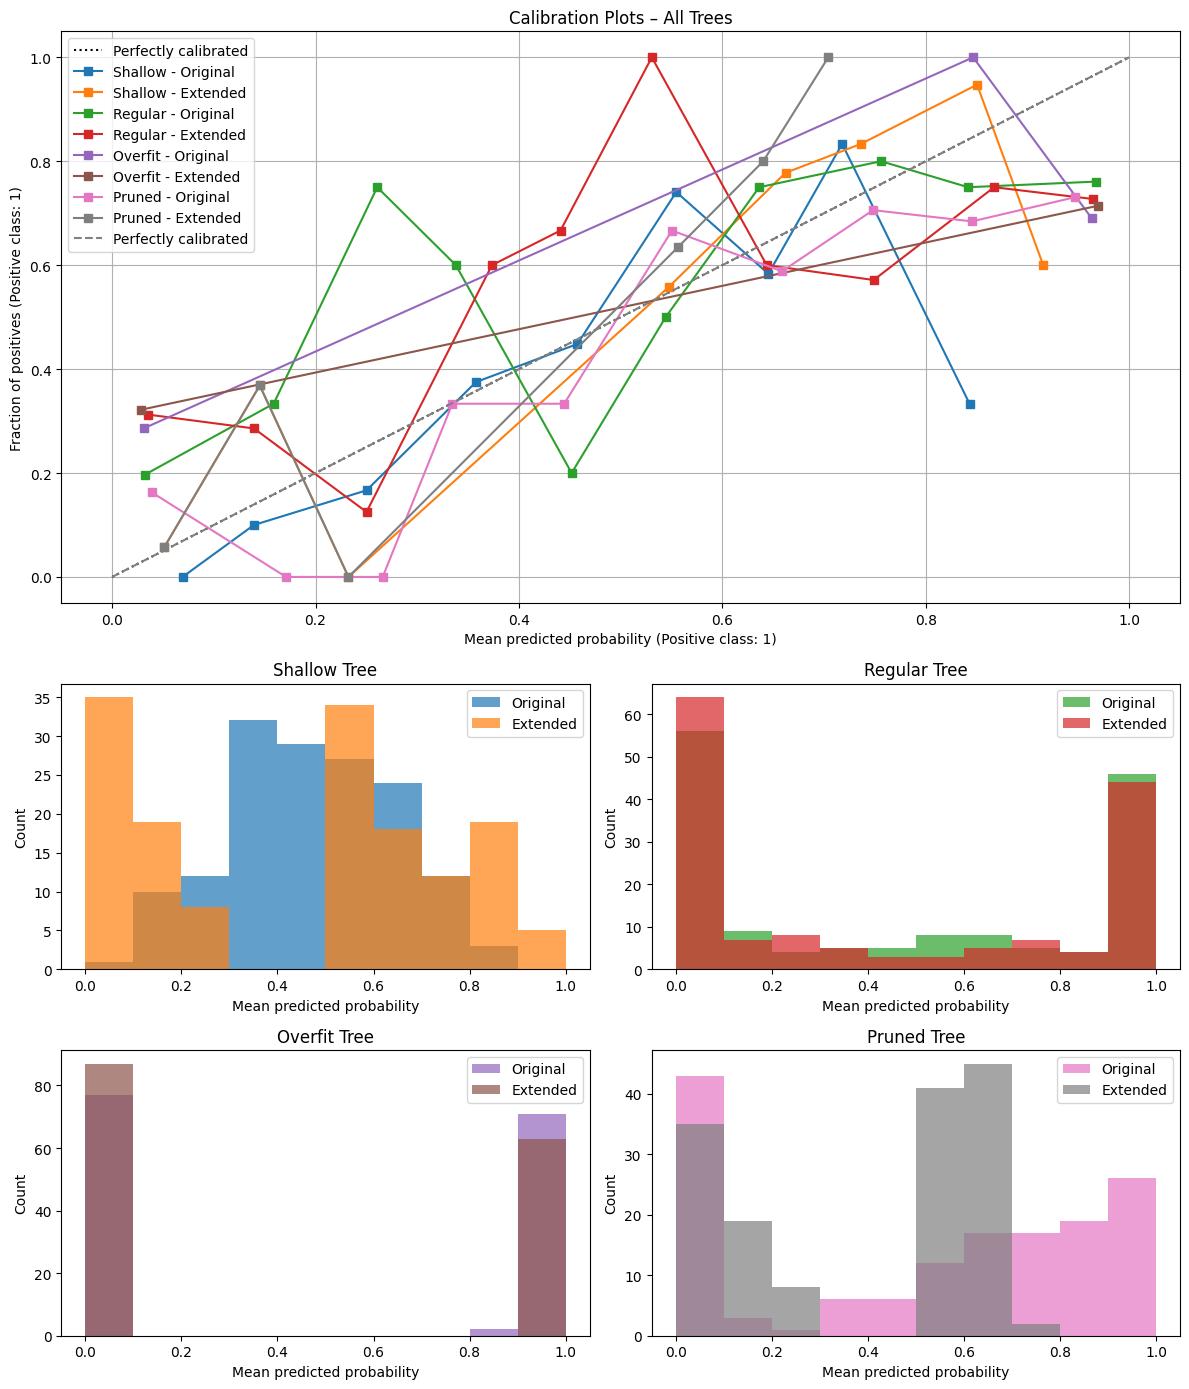

In [25]:
# Call the plotting function
plot_lmt_combined_calibration_and_hists(
    X_test[:,:2], y_test,
    X_test, y_test,
    clfs=[clf_shallow2, clf_regular2, clf_overfit2, clf_pruned2],
    nodes=[nodes_shallow2, nodes_regular2, nodes_overfit2, nodes_pruned2],
    clfs_ext=[clf_shallow_ext2, clf_regular_ext2, clf_overfit_ext2, clf_pruned_ext2],
    nodes_ext=[nodes_shallow_ext2, nodes_regular_ext2, nodes_overfit_ext2, nodes_pruned_ext2],
    model_labels=["Shallow", "Regular", "Overfit", "Pruned"]
)

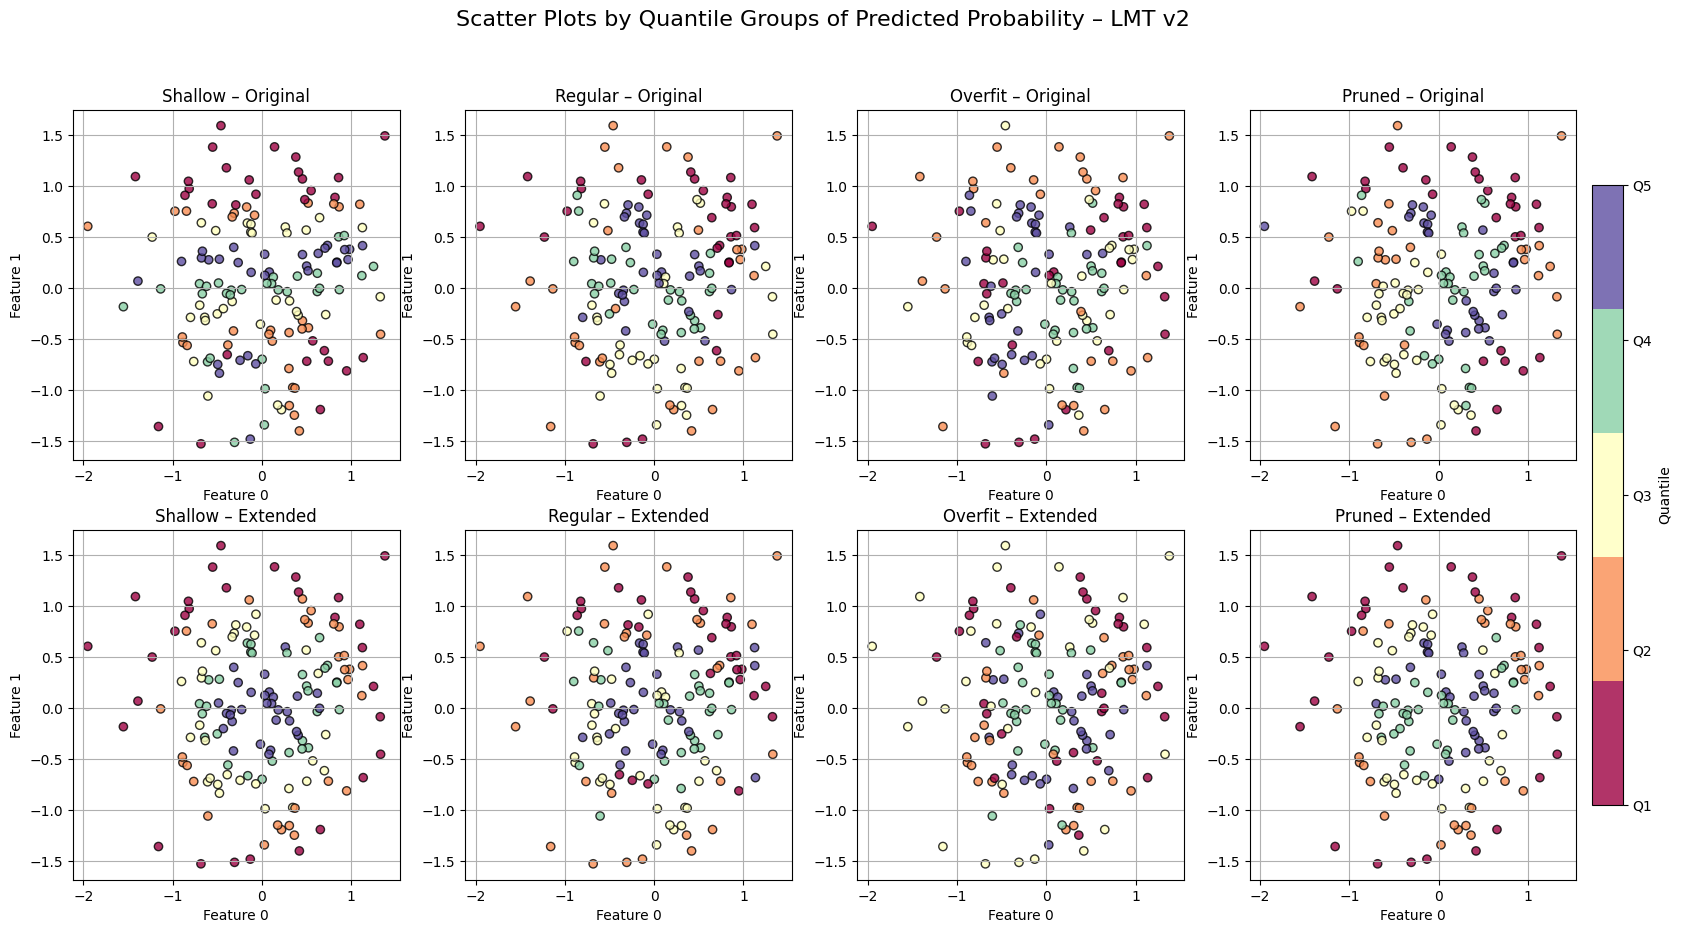

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
model_labels = ["Shallow", "Regular", "Overfit", "Pruned"]

# Top row – Original LMT models
for idx, (clf, node_model) in enumerate(zip(
    [clf_shallow2, clf_regular2, clf_overfit2, clf_pruned2],
    [nodes_shallow2, nodes_regular2, nodes_overfit2, nodes_pruned2]
)):
    y_proba = lmt.predict_proba_lmt(X_test[:, :2], clf, node_model)
    X_vis = X_test[:, :2]
    ax = axes[0, idx]
    scatter = calibration.plot_scatter_by_quantile(
        X_vis, y_proba, n_quantiles=5,
        title=f"{model_labels[idx]} – Original",
        ax=ax,
        cmap='Spectral'
    )

# Bottom row – Extended LMT models
for idx, (clf, node_model) in enumerate(zip(
    [clf_shallow_ext2, clf_regular_ext2, clf_overfit_ext2, clf_pruned_ext2],
    [nodes_shallow_ext2, nodes_regular_ext2, nodes_overfit_ext2, nodes_pruned_ext2]
)):
    y_proba = lmt.predict_proba_lmt(X_test, clf, node_model)
    X_vis = X_test[:, :2]
    ax = axes[1, idx]
    scatter = calibration.plot_scatter_by_quantile(
        X_vis, y_proba, n_quantiles=5,
        title=f"{model_labels[idx]} – Extended",
        ax=ax,
        cmap='Spectral'
    )

# Add shared colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Quantile")
cbar.set_ticks(range(5))
cbar.set_ticklabels([f"Q{i+1}" for i in range(5)])

fig.suptitle("Scatter Plots by Quantile Groups of Predicted Probability – LMT v2", fontsize=16)
plt.show()
